In [1]:
import torch
import tqdm
import torch.nn as nn
from torchvision.models import resnet18

E:\Anaconda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import pandas as pd
import os
from scipy.io import wavfile
from scipy.signal import stft
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import librosa as lr
from spafe.features.gfcc import gfcc
from sklearn.preprocessing import StandardScaler
import time
import torch
import torch.nn as nn
from torchvision.models import resnet50
from PIL import Image
import io
from tqdm import tqdm
import time
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [3]:
def test_split(leng):
    t=150
    if (leng/2)<150:
        t=int(leng/2)
    return t

In [4]:
model = resnet18(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Remove the final fully connected layer to get features before classification
model = torch.nn.Sequential(*(list(model.children())[:-1]))

E:\Anaconda\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 112*9)),  # ResNet-18 expects images of size (224, 224)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
def feature_extractor(image_folder):    
    pooled_features_list = []
    # Iterate over all images in the folder
    for filename in tqdm(os.listdir(image_folder),desc="Processing"):
        time.sleep(0.1)
        if filename.endswith(('.jpg')):
            # Load and preprocess the input image
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path).convert('RGB')
            input_tensor = transform(image)
            input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

            # Wrap the input tensor with Variable (needed for PyTorch versions before 1.0)
            input_batch = Variable(input_batch, requires_grad=False)
            split_len=224
            overlap=112
            num_splits=8
            segment_features_list = []
            for i in range(num_splits):
                start=i*overlap
                end=start+split_len
                segment=input_batch[:,:,:,start:end]
                # Forward pass up to the average pooling layer
                with torch.no_grad():
                    features = model(segment)

                # If there are multiple feature maps, take the average across spatial dimensions
                segment_features = torch.mean(features, dim=(2, 3))

                # Convert the tensor to a NumPy array and append to the list
                segment_features_list.append(segment_features.cpu().numpy())
            pooled_features_list.append(np.vstack(segment_features_list))
    return np.array(pooled_features_list)

In [7]:
def extract_shuffle(input_dir):
    abnor_dir=os.path.join(input_dir,"abnormal")
    nor_dir=os.path.join(input_dir,"normal")
    abnormal_data=feature_extractor(abnor_dir)
    normal_data=feature_extractor(nor_dir)
    np.random.shuffle(abnormal_data)
    np.random.shuffle(normal_data)

    t=test_split(len(abnormal_data))

    test_data=np.concatenate((normal_data[:t,:,:],abnormal_data[:t,:,:]))
    train_data=np.concatenate((normal_data[t:,:,:],abnormal_data[t:,:,:]))
    test_labels=np.concatenate((np.zeros(t),np.ones(t)))
    train_labels=np.concatenate((np.zeros(len(normal_data)-t),np.ones(len(abnormal_data)-t)))

    p1=np.random.permutation(len(test_data))
    p2=np.random.permutation(len(train_data))

    # Use tf.gather to rearrange both tensors based on the shuffled indices
    test_data = test_data[p1]
    test_labels = test_labels[p1]

    train_data = train_data[p2]
    train_labels = train_labels[p2]

    aug_train=train_data.reshape(train_data.shape[0]*train_data.shape[1],train_data.shape[2])
    aug_test=test_data.reshape(test_data.shape[0]*test_data.shape[1],test_data.shape[2])
    return aug_train,aug_test,train_labels,test_labels

In [8]:
def results_graphs(aug_train,aug_test,train_labels,test_labels,feature_,dataset_):    
    gmm = GaussianMixture(n_components=2)  # You can choose an appropriate number of components
    gmm.fit(aug_train)

    # Get GMM predictions for the training and testing data
    gmm_preds_test = gmm.predict(aug_test)
    gmm_preds_train= gmm.predict(aug_train)
    y_true=test_labels
    y_true_train=train_labels
    y_pred=np.average(gmm_preds_test.reshape(int(len(gmm_preds_test)/8),8),axis=1)
    y_pred_train=np.average(gmm_preds_train.reshape(int(len(gmm_preds_train)/8),8),axis=1)
    pred_auc = roc_auc_score(y_true, y_pred)
    if pred_auc<0.5:
        y_true=np.logical_not(y_true).astype(int)
        y_true_train=np.logical_not(y_true_train).astype(int)
    pred_auc = roc_auc_score(y_true, y_pred)
    pred_auc_train =roc_auc_score(y_true_train, y_pred_train)

    threshold = 0.5
    #Results for train dataset
    test_m1 = keras.metrics.TruePositives(thresholds=threshold, name=None, dtype=None)
    test_m1.update_state(y_true, y_pred)
    test_m2 = keras.metrics.FalsePositives(thresholds=threshold, name=None, dtype=None)
    test_m2.update_state(y_true, y_pred)
    test_m3 = keras.metrics.FalseNegatives(thresholds=threshold, name=None, dtype=None)
    test_m3.update_state(y_true, y_pred)
    test_m4 = keras.metrics.TrueNegatives(thresholds=threshold, name=None, dtype=None)
    test_m4.update_state(y_true, y_pred)

    train_m1 = keras.metrics.TruePositives(thresholds=threshold, name=None, dtype=None)
    train_m1.update_state(y_true_train, y_pred_train)
    train_m2 = keras.metrics.FalsePositives(thresholds=threshold, name=None, dtype=None)
    train_m2.update_state(y_true_train, y_pred_train)
    train_m3 = keras.metrics.FalseNegatives(thresholds=threshold, name=None, dtype=None)
    train_m3.update_state(y_true_train, y_pred_train)
    train_m4 = keras.metrics.TrueNegatives(thresholds=threshold, name=None, dtype=None)
    train_m4.update_state(y_true_train, y_pred_train)

    base = [0 for _ in range(len(y_true))]
    base_auc = roc_auc_score(y_true, base)
    pred_auc = roc_auc_score(y_true, y_pred)
    print('Model predicted: ROC AUC=%.3f' % (pred_auc))

    base_fpr, base_tpr, _ = roc_curve(y_true, base)
    pred_fpr, pred_tpr, _ = roc_curve(y_true, y_pred)
    file_name1="F:\\Results\\GFCC\\ROC_"+feature_+"_"+dataset_+".png"
    plt.figure(figsize=(5,5))
    plt.plot(base_fpr, base_tpr, linestyle='--', label='Base', color = 'b')
    plt.plot(pred_fpr, pred_tpr, label='Model predicted (test dataset)', marker = "o", markersize = 5, color = 'g', alpha = 0.5)
    plt.xlabel('False Positive Rate', fontsize = 13)
    plt.ylabel('True Positive Rate', fontsize = 13)
    plt.text(0.25, 0.14, f'▶ AUC: {pred_auc: 3.3f}', fontsize = 12)
    plt.text(0.25, 0.20, f'▶ Dataset name: {dataset_}', fontsize = 12)
    plt.text(0.25, 0.26, f'▶ Feature method: {feature_}', fontsize = 12)
    plt.legend()
    plt.savefig(file_name1)
    plt.show()

    # Plot PR curve
    from sklearn.metrics import PrecisionRecallDisplay
    from sklearn.metrics import average_precision_score
    display = PrecisionRecallDisplay.from_predictions(
        y_true, y_pred, name="Model predicted", plot_chance_level=True
        )
    ap = average_precision_score(y_true, y_pred)
    chance_level = sum(y_true) / len(y_true)

    plt.figure()
    display.plot()
    chance_line=chance_level*np.ones(2)
    plt.plot(chance_line, "--", color = 'black')
    file_name2="F:\\Results\\GFCC\\PR_Curve_"+feature_+"_"+dataset_+".png"
    plt.title(f'Precision-Recall Curve\nAverage Precision: {ap:.2f}, Chance Level: {chance_level:.2f}')
    plt.savefig(file_name2)
    plt.show()

    threshold_line = threshold*np.ones(len(y_true))

    # Plot the results: test dataset
    s = y_true.argsort()
    y_true_2 = y_true[s]
    y_pred_2 = y_pred[s]
    y_compare = np.hstack((y_true_2.reshape(len(y_true),1), y_pred_2.reshape(len(y_true),1)))

    plt.figure(figsize=(8,4))
    plt.title("")
    plt.plot(y_compare[:,1], "o", alpha = 0.5, color = 'r', markersize = 5, label = 'Predicted values')
    plt.plot(y_compare[:,0], "o", alpha = 0.5, color = 'b', markersize = 5, label = 'Target values (1 = abnormal, 0 = normal)')
    plt.plot(threshold_line, ":", color = 'black', label = f'Threshold line = {threshold}')
    plt.xlabel('Test dataset samples', fontsize = 13)
    plt.ylabel('Predicted value [0,1]', fontsize = 13)
    plt.ylim(0,1)
    plt.legend(loc = (0.02, 0.1), fontsize = 13)
    plt.text(0.02, 0.55, f'▶ Feature method: {feature_}, Dataset name: {dataset_}', fontsize = 12)
    file_name3="F:\\Results\\GFCC\\Distribution_"+feature_+"_"+dataset_+".png"
    plt.savefig(file_name3)
    plt.show()

    test_accuracy=(test_m1.result().numpy()+test_m4.result().numpy())/(test_m1.result().numpy()+test_m2.result().numpy()+test_m3.result().numpy()+test_m4.result().numpy())
    train_accuracy=(train_m4.result().numpy()+train_m1.result().numpy())/(train_m4.result().numpy()+train_m1.result().numpy()+train_m2.result().numpy()+train_m3.result().numpy())

    new_data = {"Method":feature_, "Dataset":dataset_, 
                "ROC_curve_AUC_test":pred_auc, "PR_curve_AP_test" : ap, "PR_curve_Chance_level":chance_level,
                "TP_train":train_m1.result().numpy(), "FP_train":train_m2.result().numpy(),
                "FN_train":train_m3.result().numpy(),"TN_train":train_m4.result().numpy(),
                "TP_test":test_m1.result().numpy(), "FP_test":test_m2.result().numpy(),
                "FN_test":test_m3.result().numpy(),"TN_test":test_m4.result().numpy(),
                "Accuracy_test":test_accuracy,"Accuracy_train":train_accuracy
                }
    return new_data

In [9]:
id_no=["id_00\\","id_02\\","id_04\\","id_06\\"]
output_tag=["0_dB_fan\\","6_dB_fan\\","-6_dB_fan\\","0_dB_valve\\","6_dB_valve\\","-6_dB_valve\\","0_dB_slider\\",
           "6_dB_slider\\","-6_dB_slider\\","0_dB_pump\\","6_dB_pump\\","-6_dB_pump\\",]
direc_out=[]
for out in output_tag:
    for mac in id_no:
        direc_out.append("F:\\GFCC\\"+out+mac)

In [10]:
col_names = ["Method", "Dataset", "ROC_curve_AUC_test", "PR_curve_AP_test", "PR_curve_Chance_level",
           "TP_train", "FP_train","FN_train","TN_train", "TP_test", "FP_test", "FN_test","TN_test",
             "Accuracy_test", "Accuracy_train"]
df_saved_results = pd.DataFrame(columns = col_names)
result_list=[]

*********************************
Iteration:0
*********************************


Processing: 100%|██████████| 1011/1011 [03:59<00:00,  4.22it/s]


Model predicted: ROC AUC=0.569


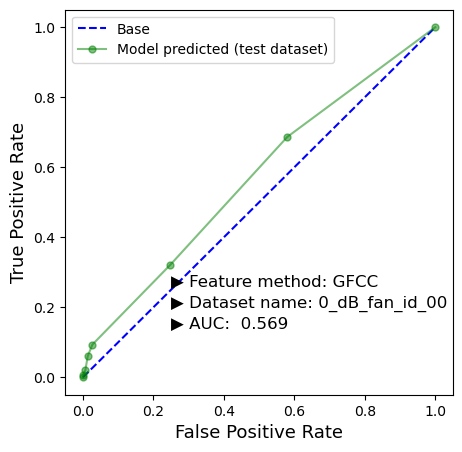

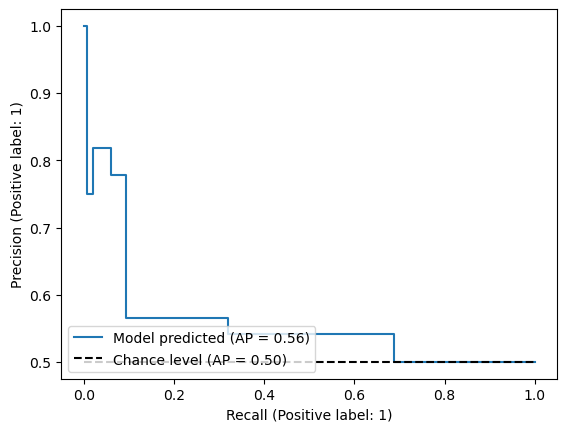

<Figure size 640x480 with 0 Axes>

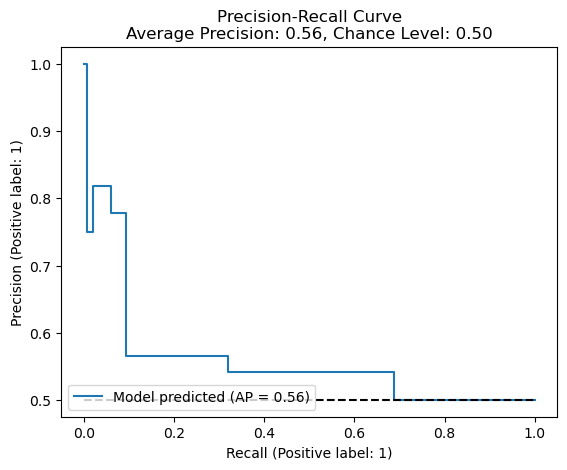

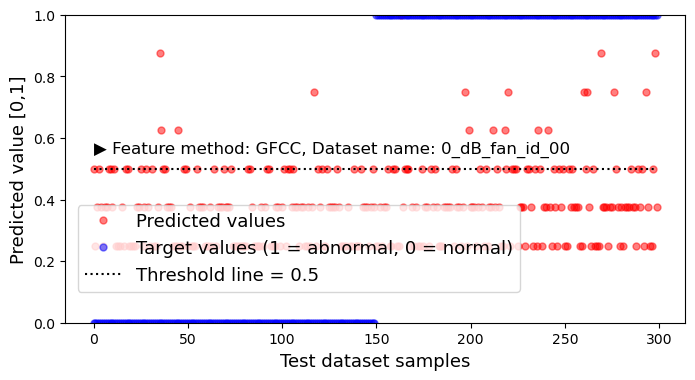

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:1
*********************************


Processing: 100%|██████████| 1016/1016 [04:00<00:00,  4.22it/s]


Model predicted: ROC AUC=0.609


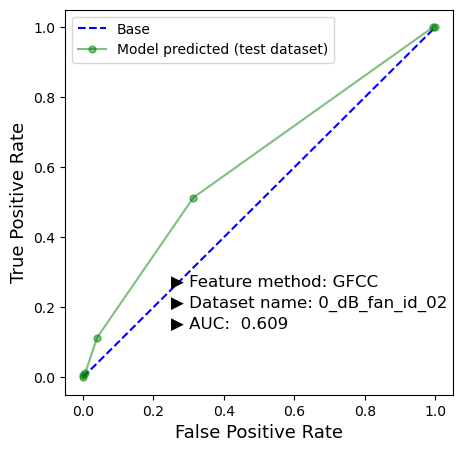

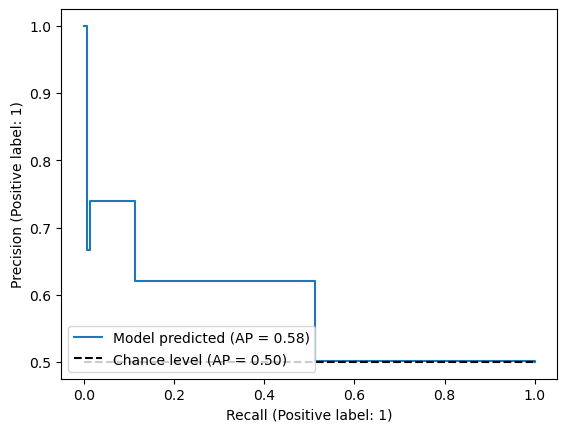

<Figure size 640x480 with 0 Axes>

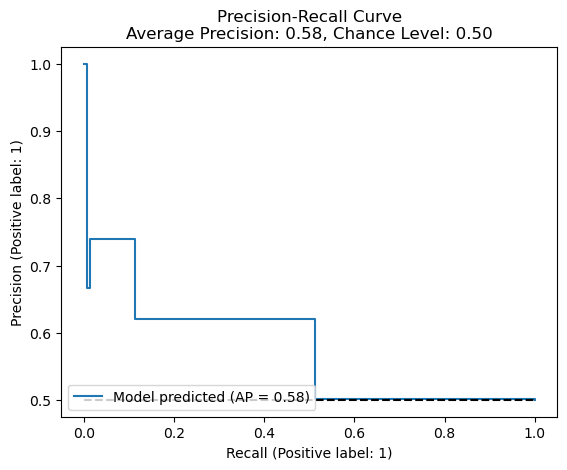

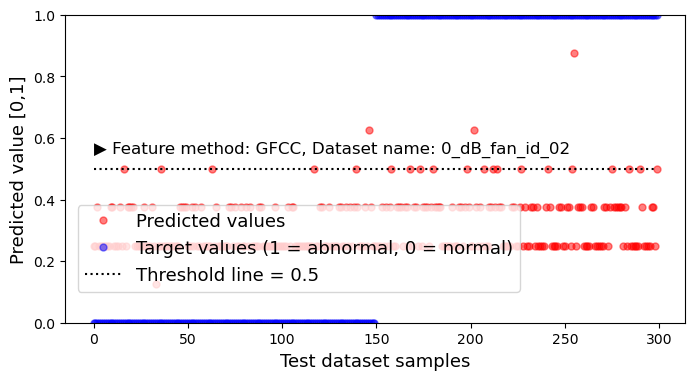

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:2
*********************************


Processing: 100%|██████████| 1033/1033 [04:04<00:00,  4.22it/s]


Model predicted: ROC AUC=0.528


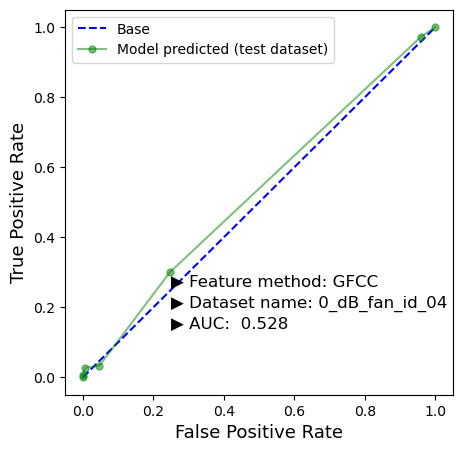

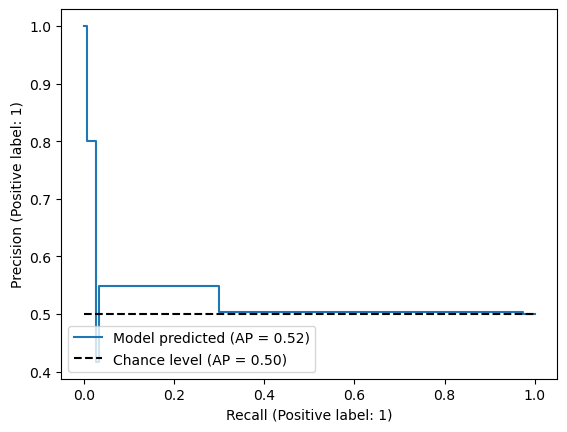

<Figure size 640x480 with 0 Axes>

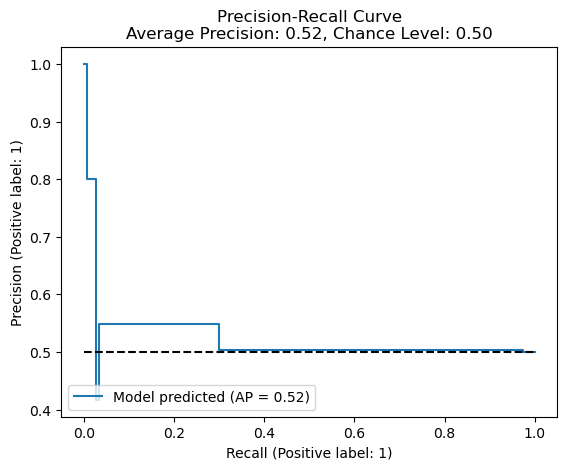

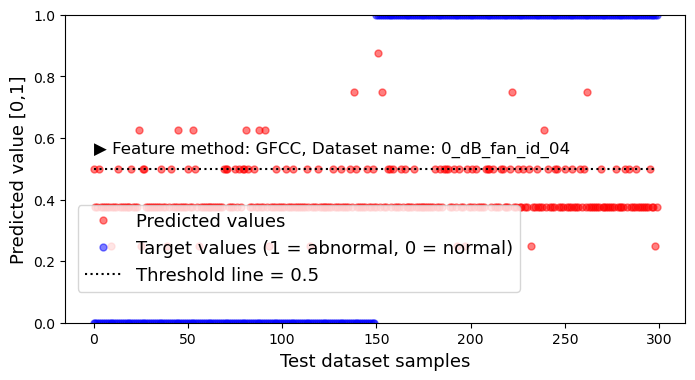

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:3
*********************************


Processing: 100%|██████████| 1015/1015 [03:56<00:00,  4.29it/s]


Model predicted: ROC AUC=0.615


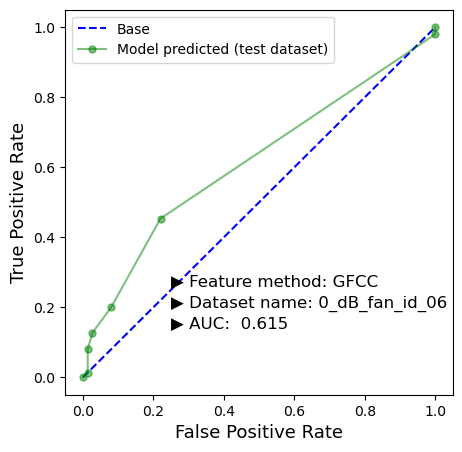

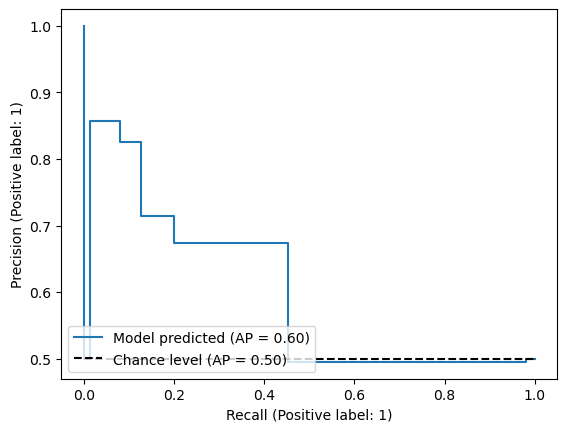

<Figure size 640x480 with 0 Axes>

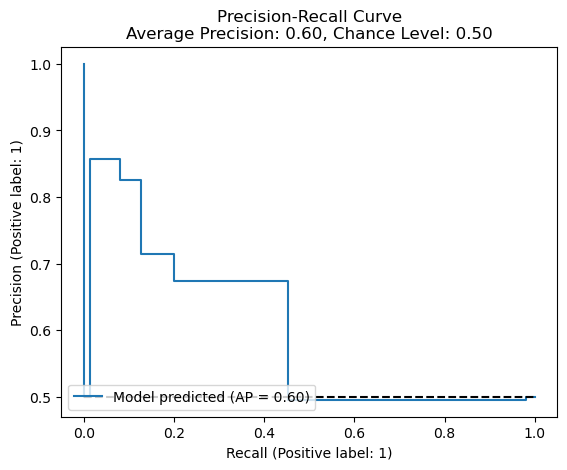

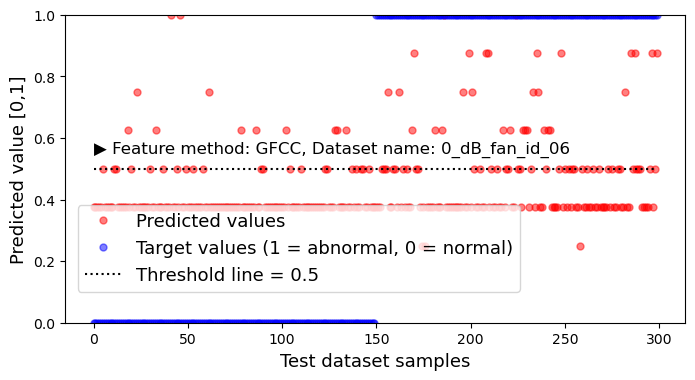

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:4
*********************************


Processing: 100%|██████████| 1011/1011 [03:56<00:00,  4.27it/s]


Model predicted: ROC AUC=0.575


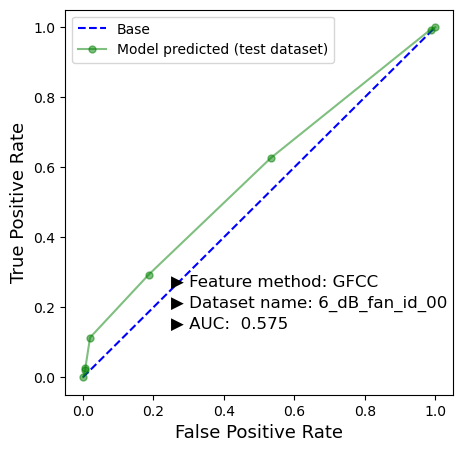

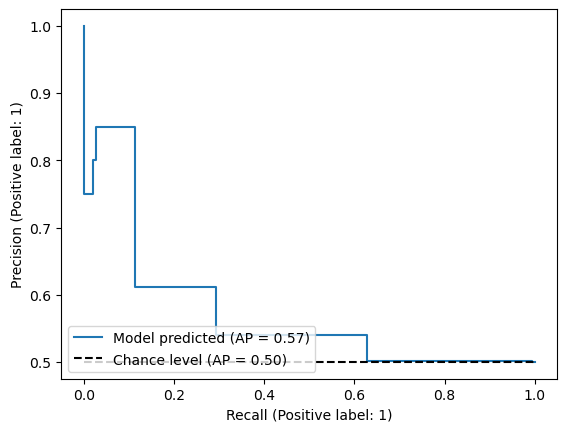

<Figure size 640x480 with 0 Axes>

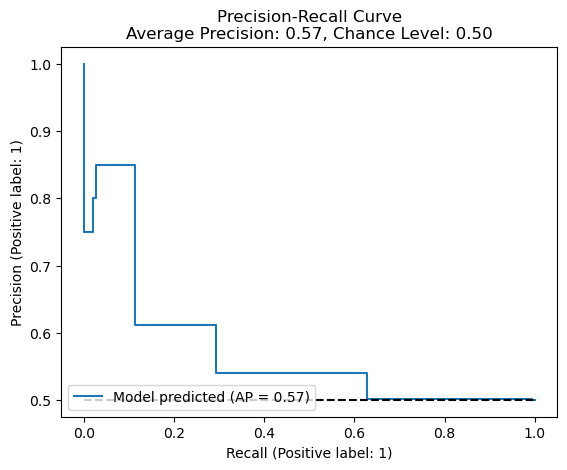

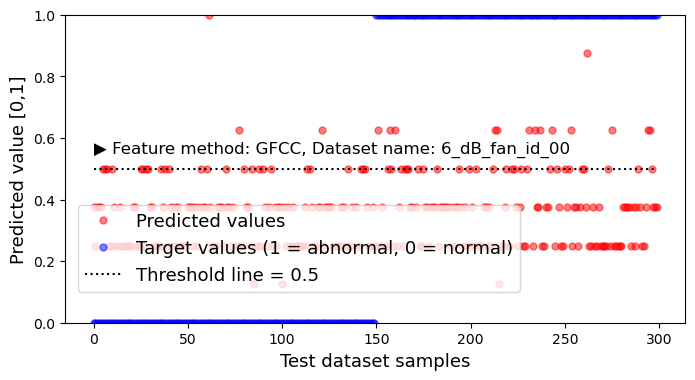

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:5
*********************************


Processing: 100%|██████████| 1016/1016 [03:58<00:00,  4.26it/s]


Model predicted: ROC AUC=0.687


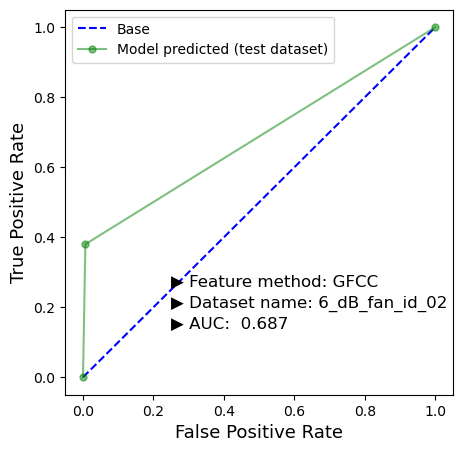

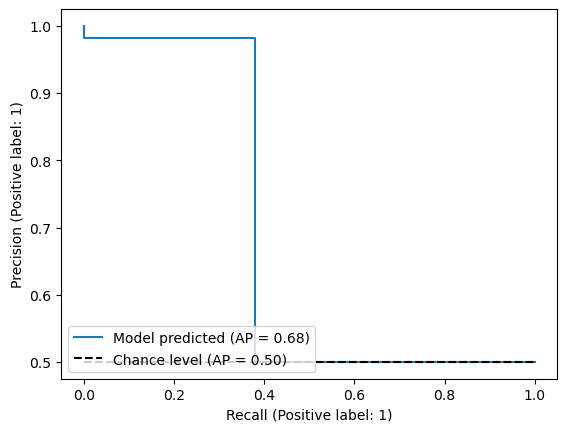

<Figure size 640x480 with 0 Axes>

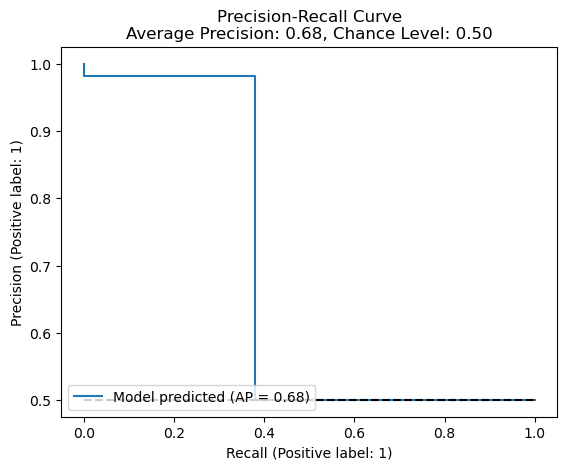

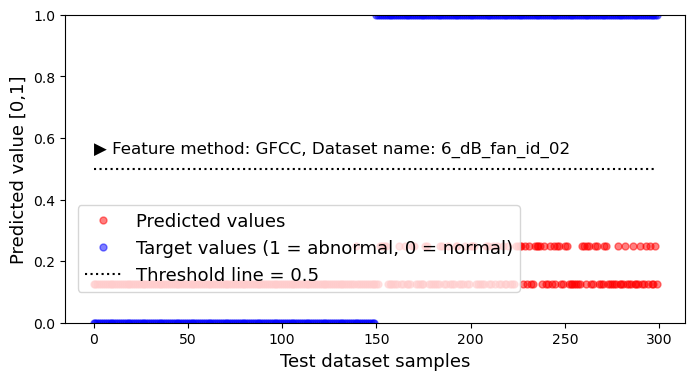

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:6
*********************************


Processing: 100%|██████████| 1033/1033 [03:57<00:00,  4.36it/s]


Model predicted: ROC AUC=0.598


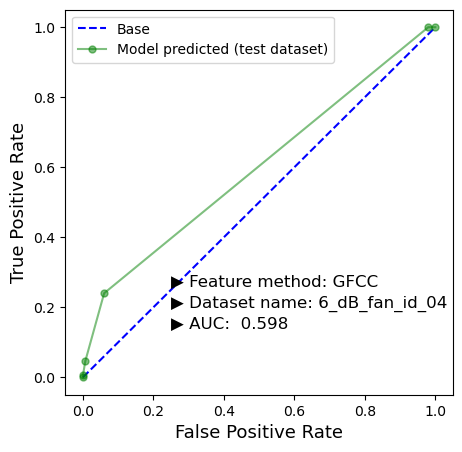

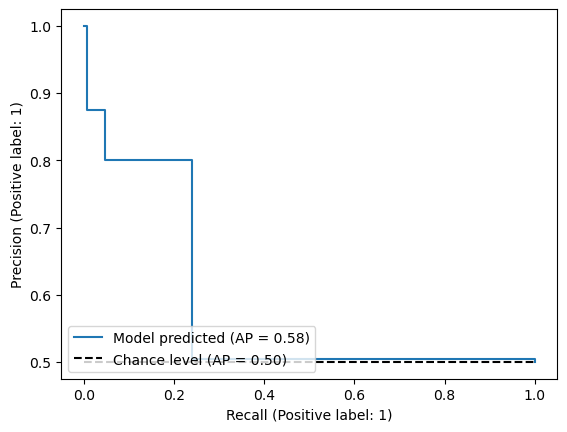

<Figure size 640x480 with 0 Axes>

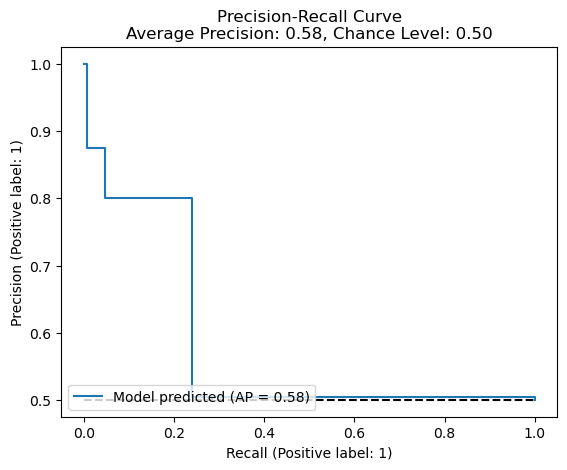

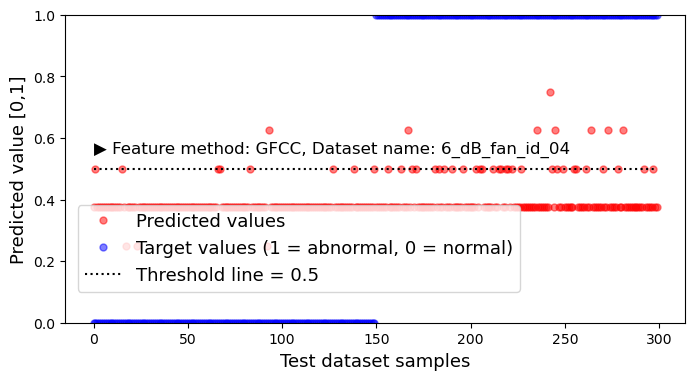

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:7
*********************************


Processing: 100%|██████████| 1015/1015 [03:57<00:00,  4.27it/s]


Model predicted: ROC AUC=0.532


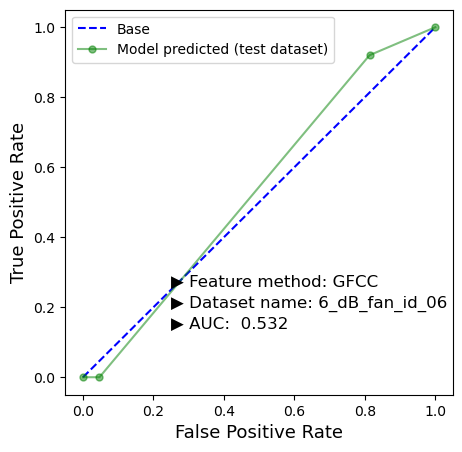

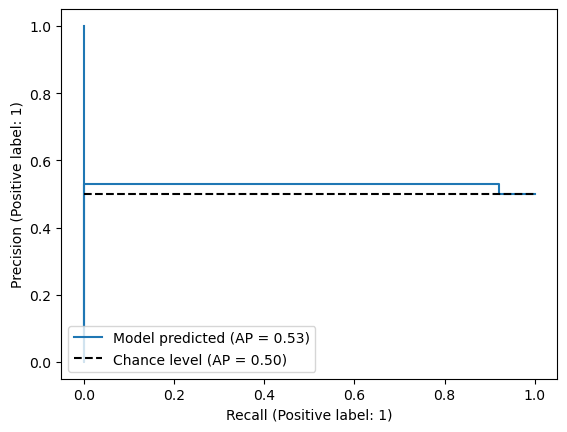

<Figure size 640x480 with 0 Axes>

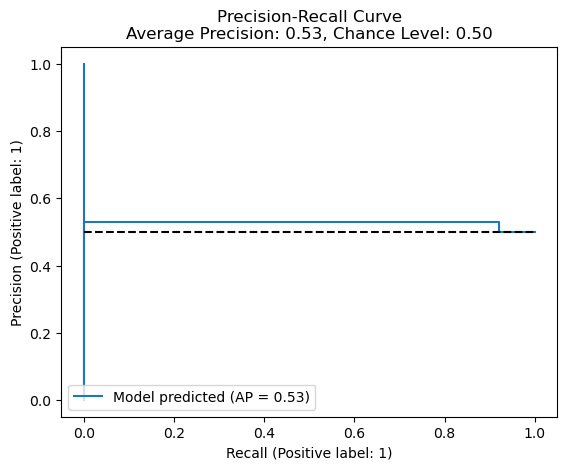

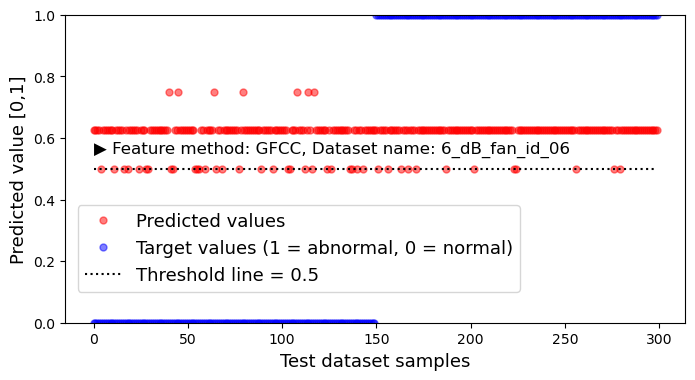

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:8
*********************************


Processing: 100%|██████████| 1011/1011 [04:01<00:00,  4.18it/s]


Model predicted: ROC AUC=0.516


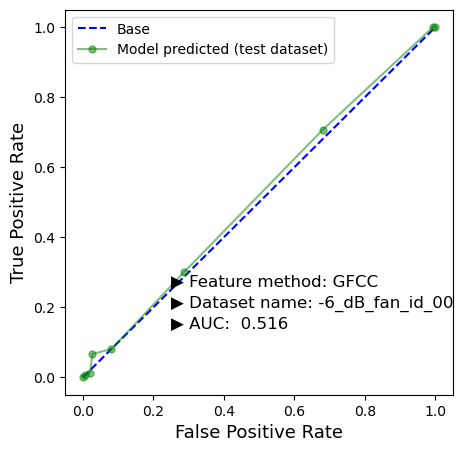

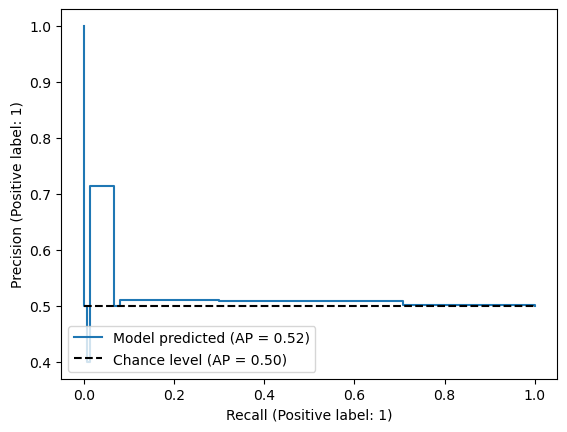

<Figure size 640x480 with 0 Axes>

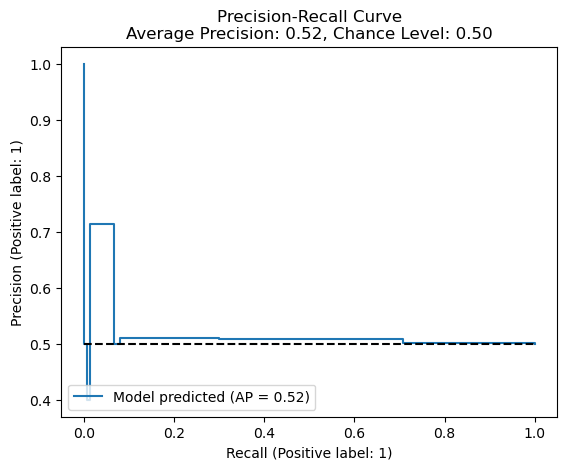

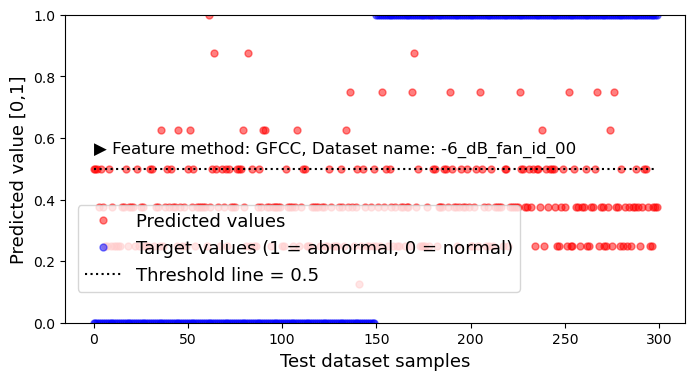

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:9
*********************************


Processing: 100%|██████████| 1016/1016 [04:04<00:00,  4.16it/s]


Model predicted: ROC AUC=0.554


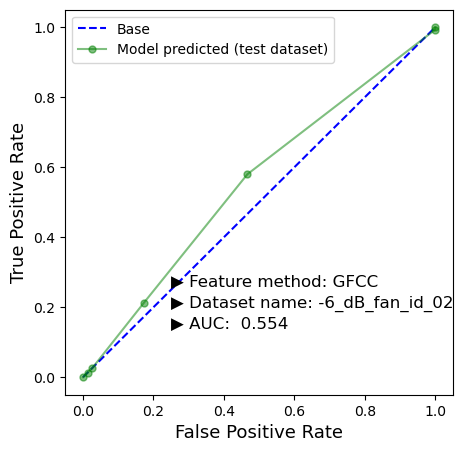

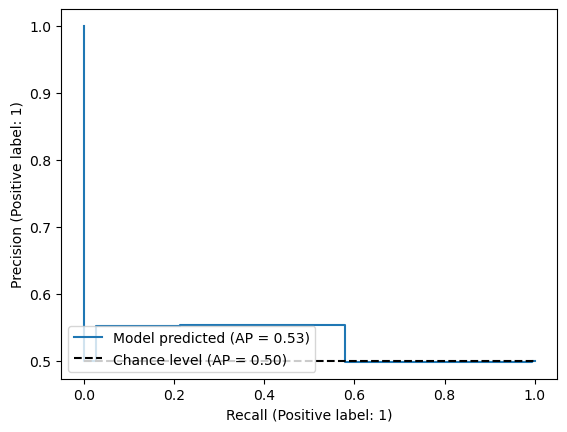

<Figure size 640x480 with 0 Axes>

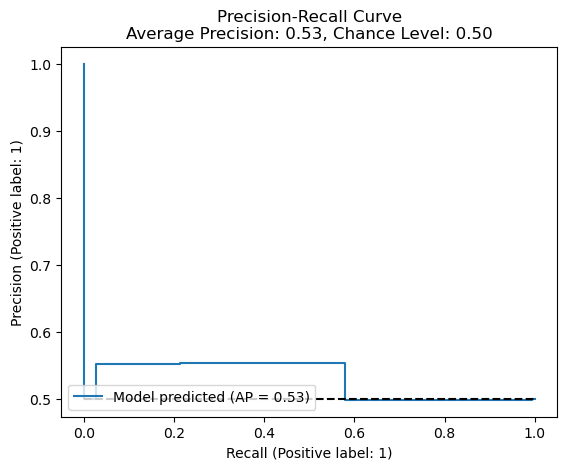

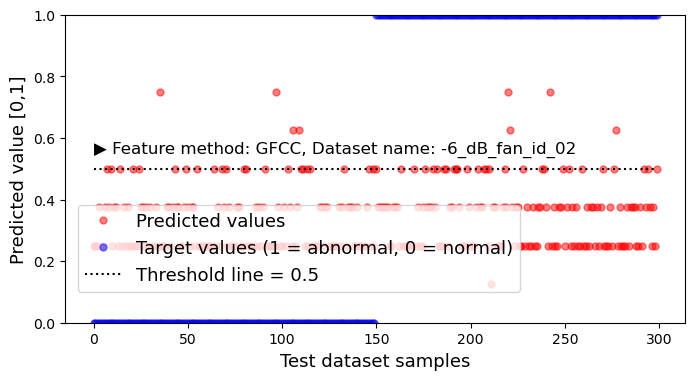

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:10
*********************************


Processing: 100%|██████████| 1033/1033 [04:05<00:00,  4.20it/s]


Model predicted: ROC AUC=0.577


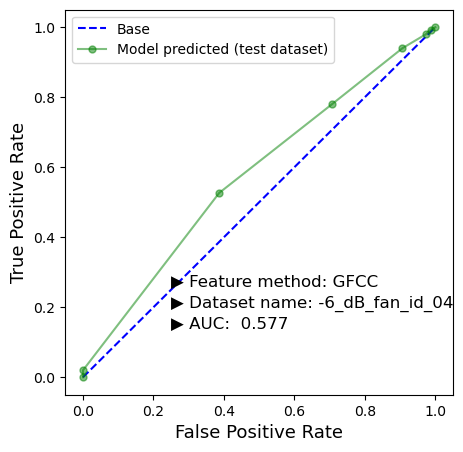

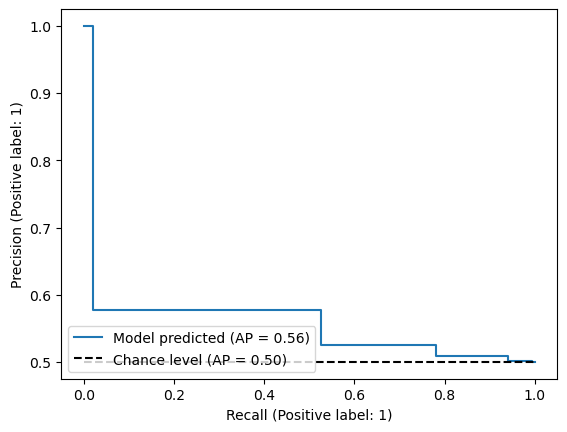

<Figure size 640x480 with 0 Axes>

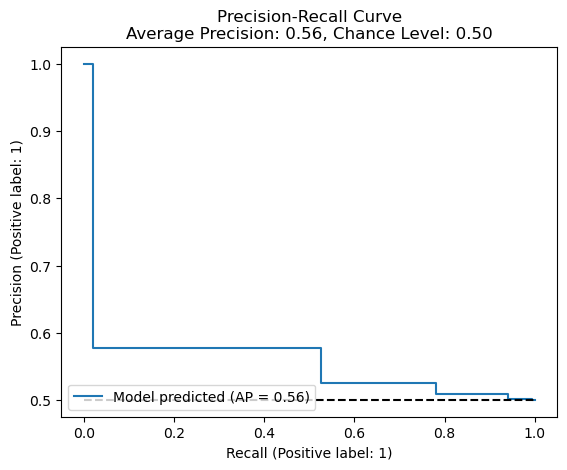

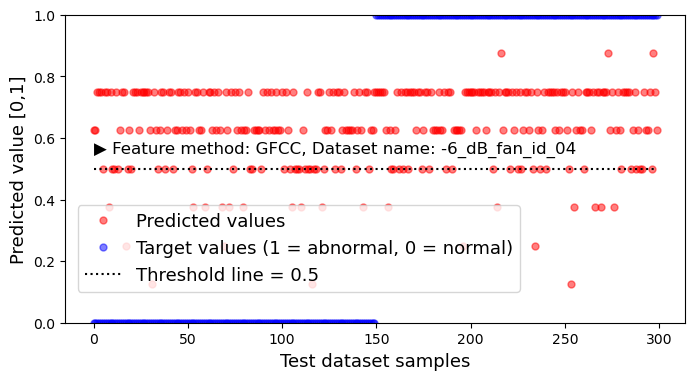

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:11
*********************************


Processing: 100%|██████████| 1015/1015 [04:04<00:00,  4.15it/s]


Model predicted: ROC AUC=0.529


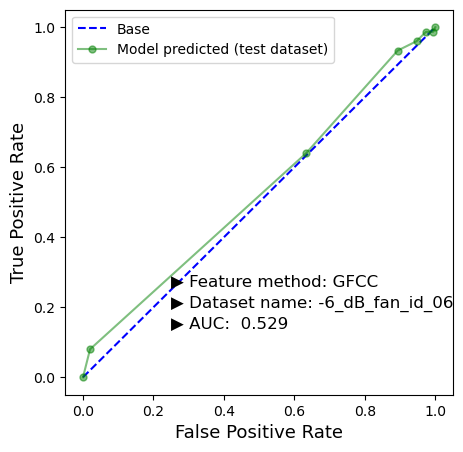

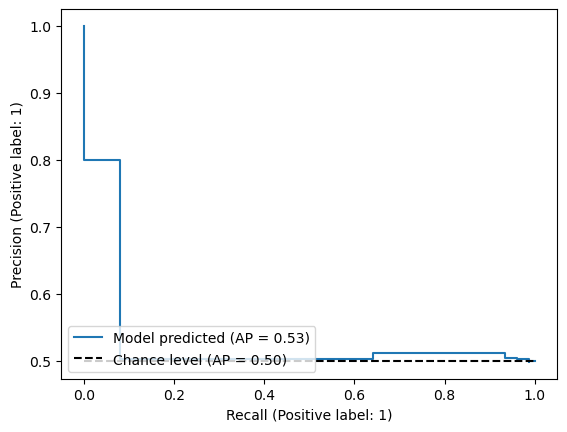

<Figure size 640x480 with 0 Axes>

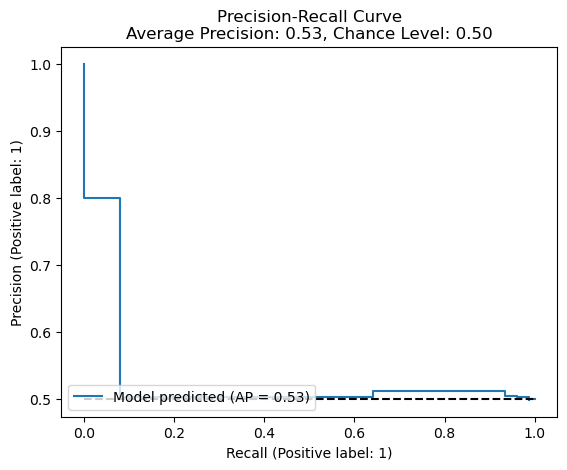

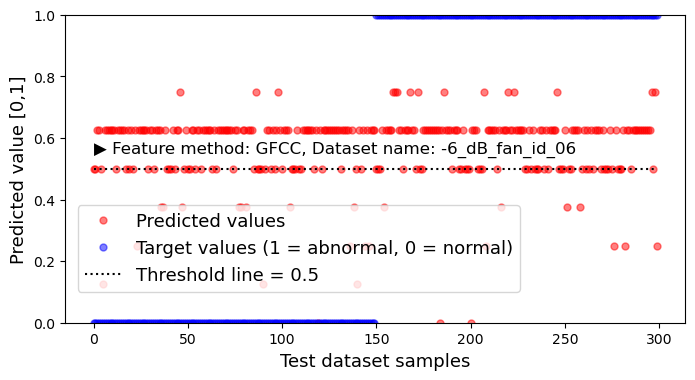

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:12
*********************************


Processing: 100%|██████████| 991/991 [03:59<00:00,  4.14it/s]


Model predicted: ROC AUC=0.768


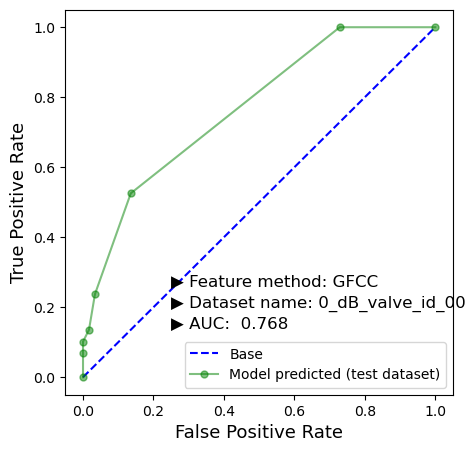

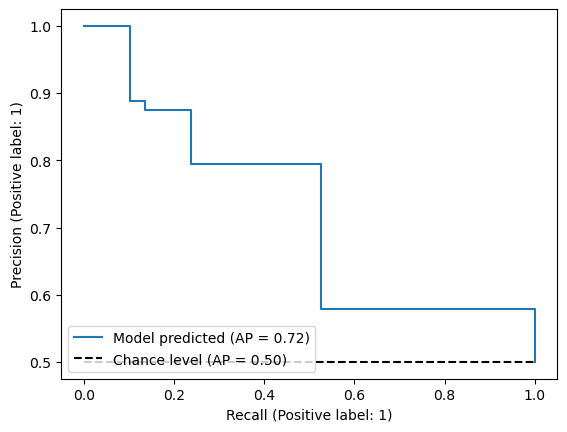

<Figure size 640x480 with 0 Axes>

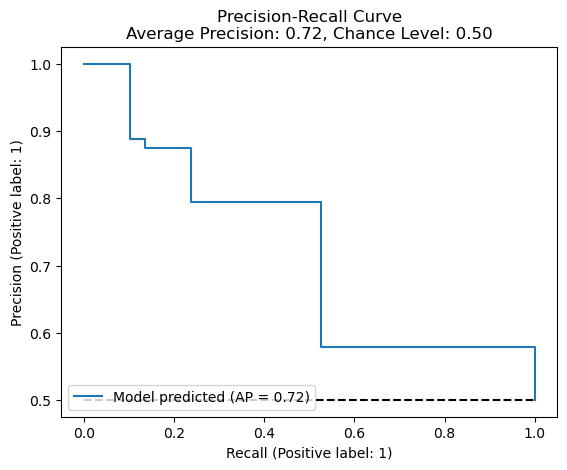

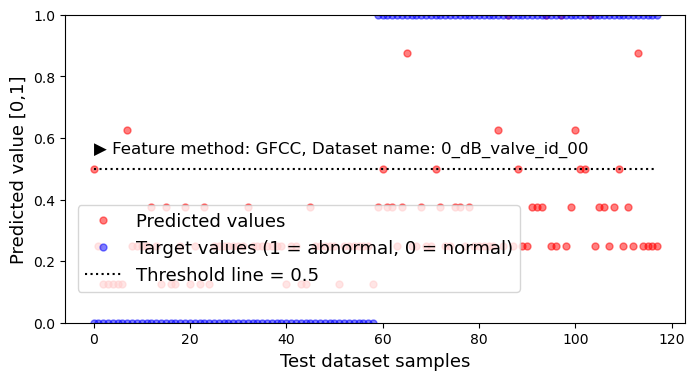

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:13
*********************************


Processing: 100%|██████████| 708/708 [02:51<00:00,  4.14it/s]


Model predicted: ROC AUC=0.508


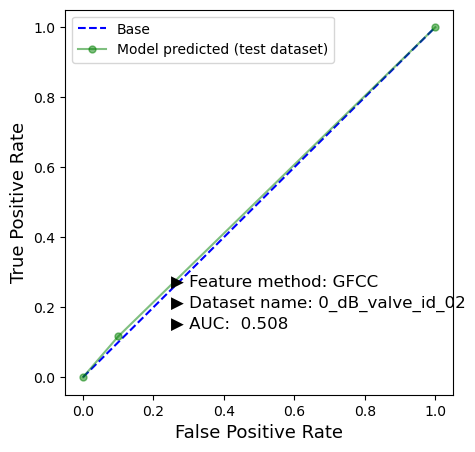

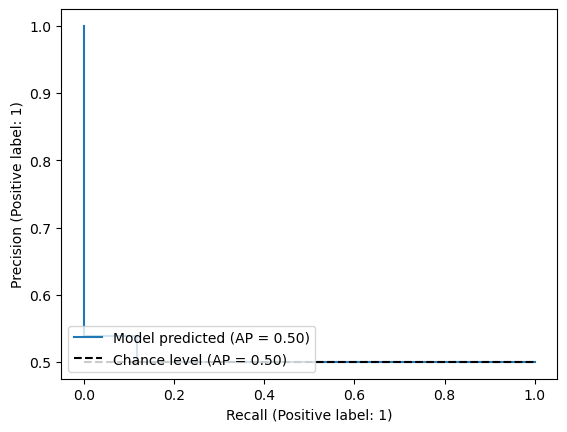

<Figure size 640x480 with 0 Axes>

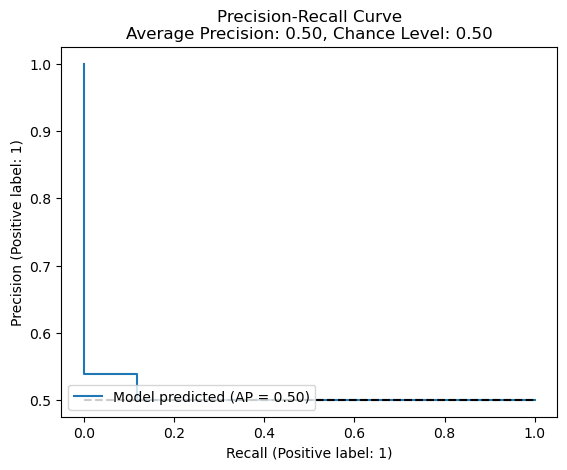

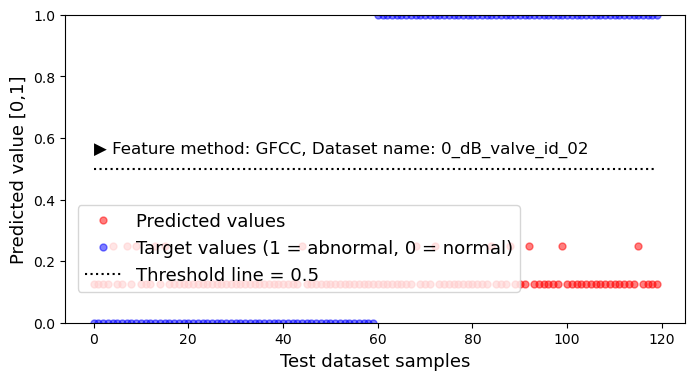

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:14
*********************************


Processing: 100%|██████████| 1000/1000 [03:59<00:00,  4.17it/s]


Model predicted: ROC AUC=0.564


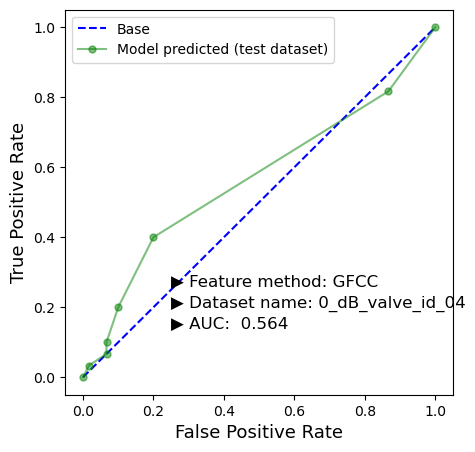

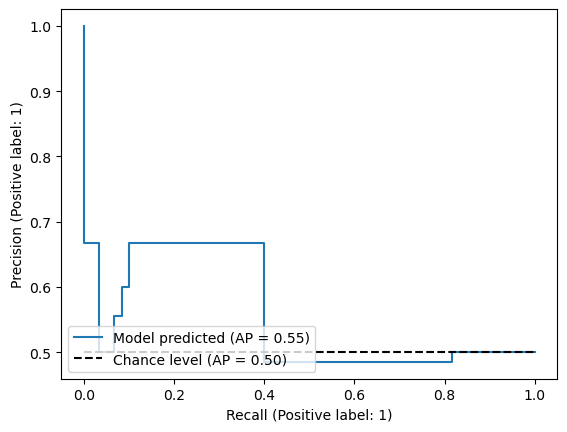

<Figure size 640x480 with 0 Axes>

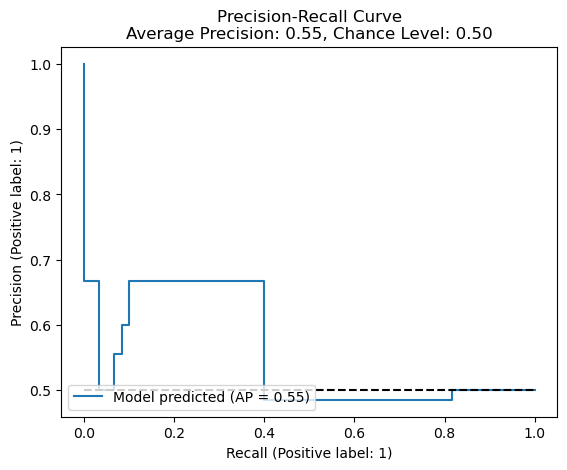

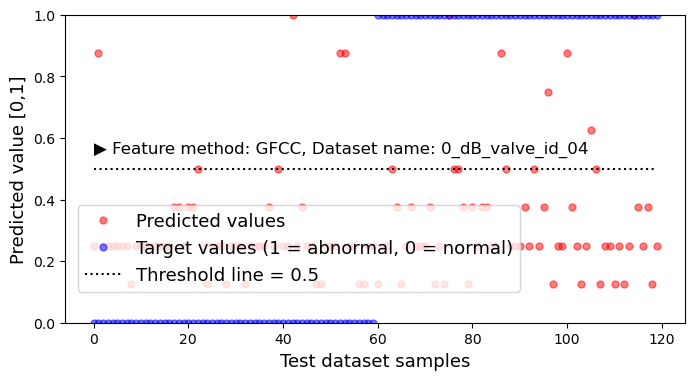

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:15
*********************************


Processing: 100%|██████████| 992/992 [03:59<00:00,  4.14it/s]


Model predicted: ROC AUC=0.500


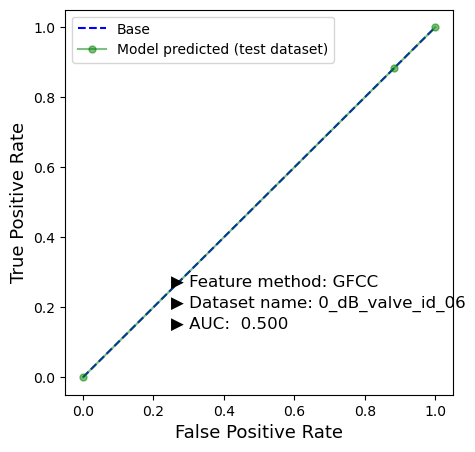

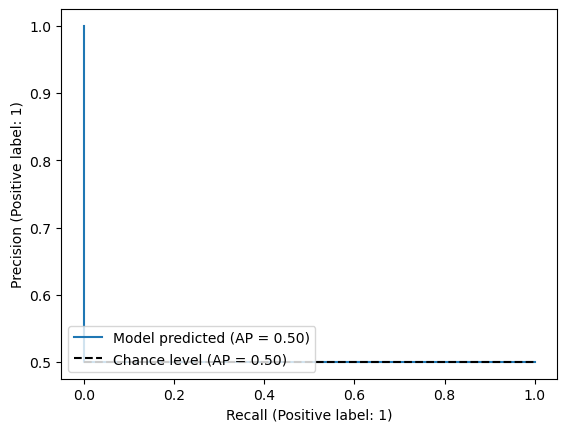

<Figure size 640x480 with 0 Axes>

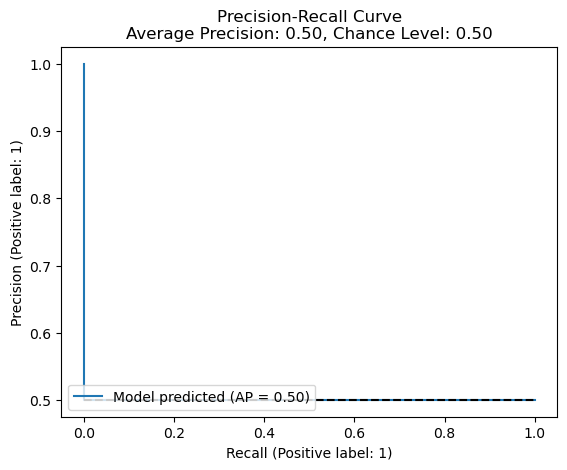

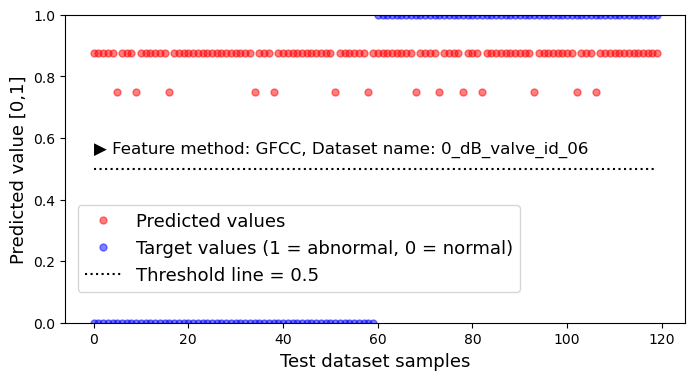

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:16
*********************************


Processing: 100%|██████████| 991/991 [03:56<00:00,  4.19it/s]


Model predicted: ROC AUC=0.645


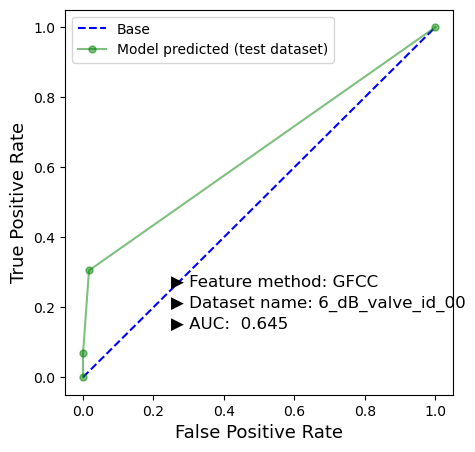

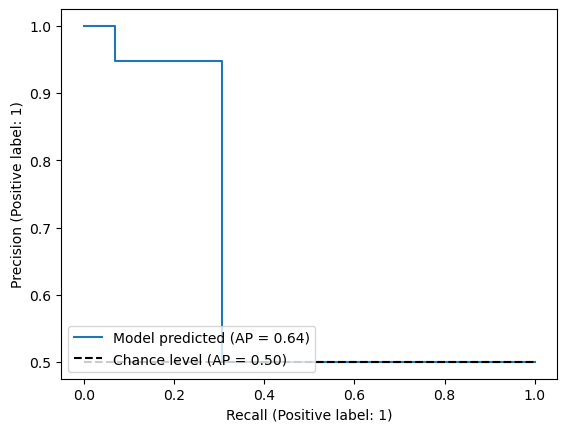

<Figure size 640x480 with 0 Axes>

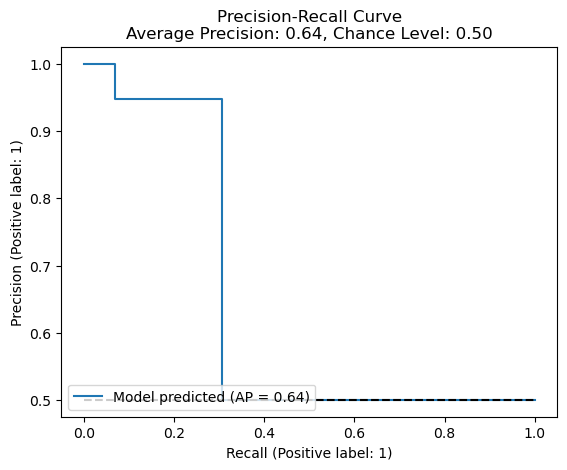

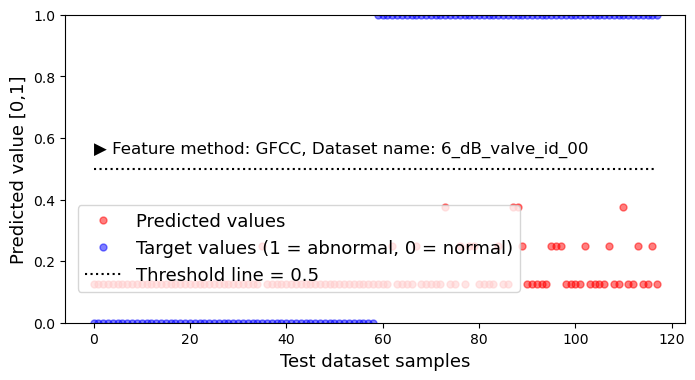

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:17
*********************************


Processing: 100%|██████████| 708/708 [02:48<00:00,  4.20it/s]


Model predicted: ROC AUC=0.558


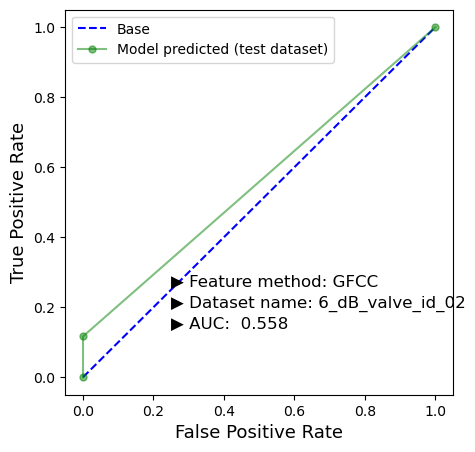

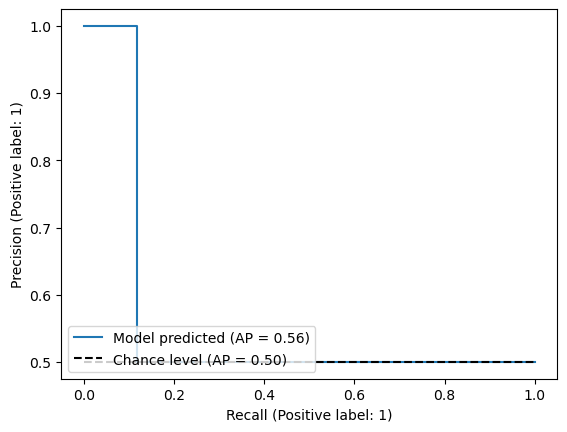

<Figure size 640x480 with 0 Axes>

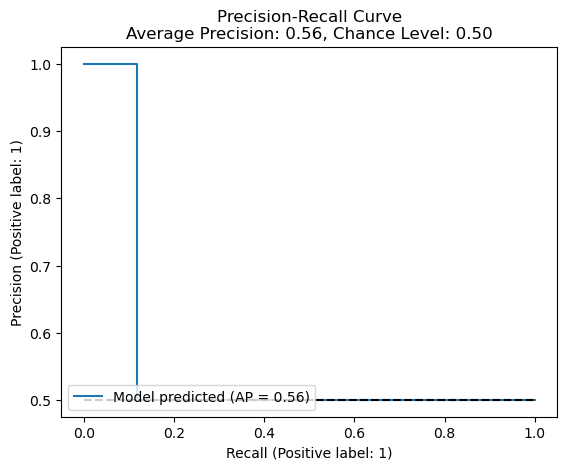

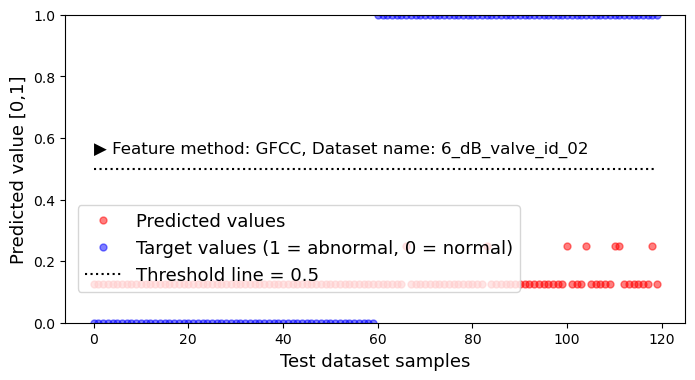

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:18
*********************************


Processing: 100%|██████████| 1000/1000 [04:01<00:00,  4.13it/s]


Model predicted: ROC AUC=0.517


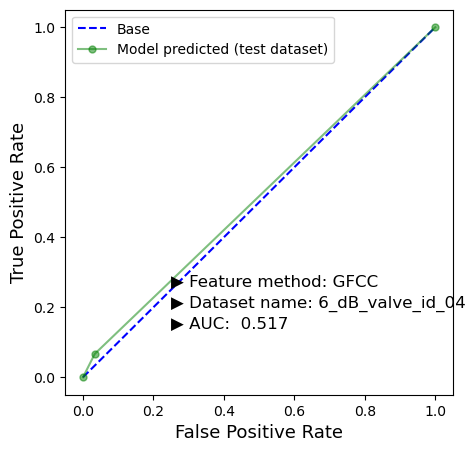

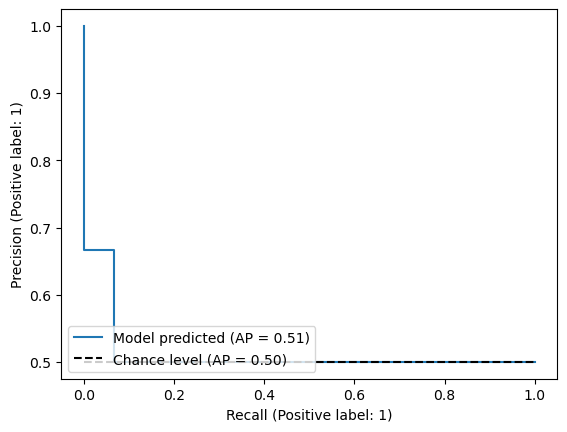

<Figure size 640x480 with 0 Axes>

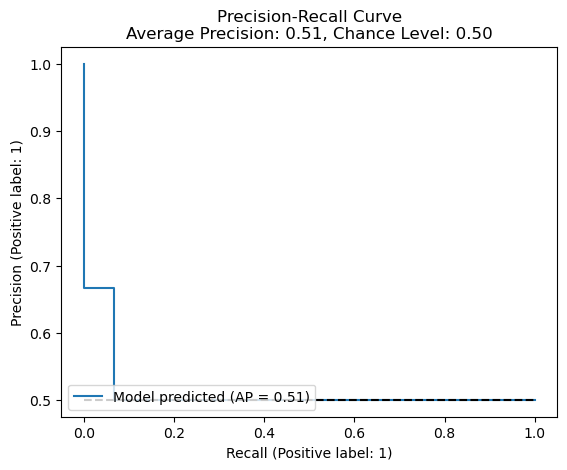

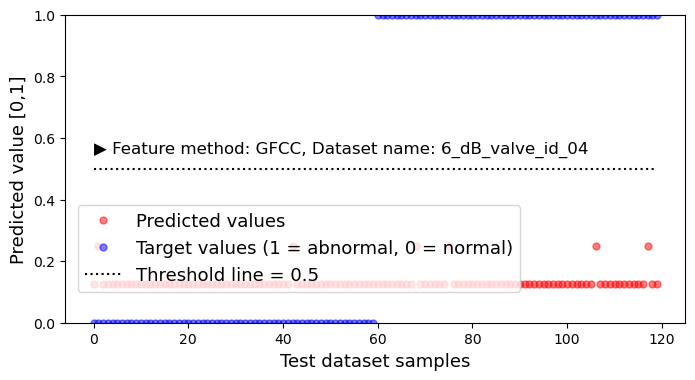

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:19
*********************************


Processing: 100%|██████████| 992/992 [03:57<00:00,  4.18it/s]


Model predicted: ROC AUC=0.547


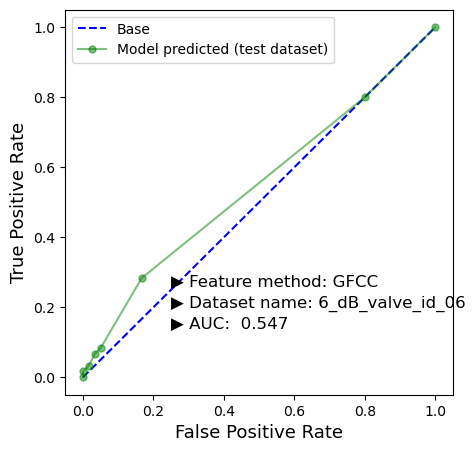

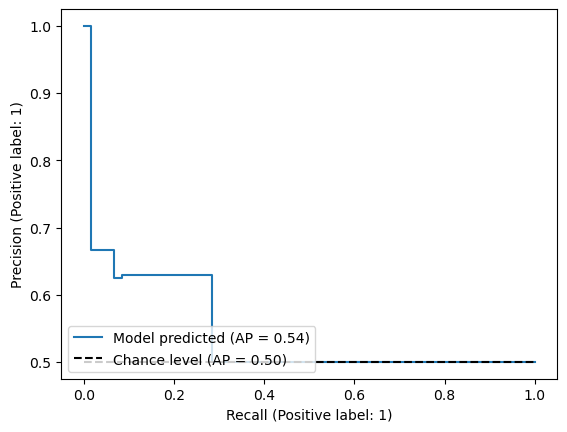

<Figure size 640x480 with 0 Axes>

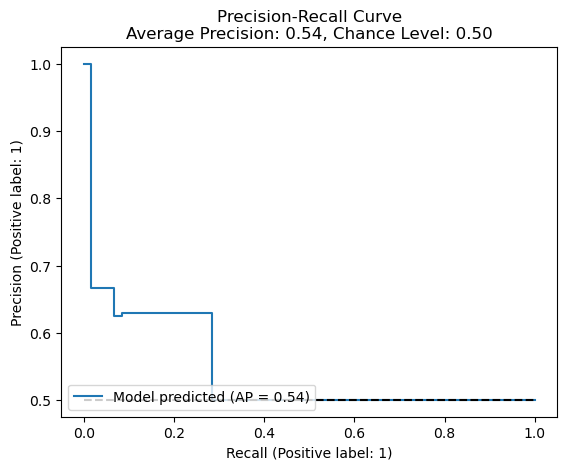

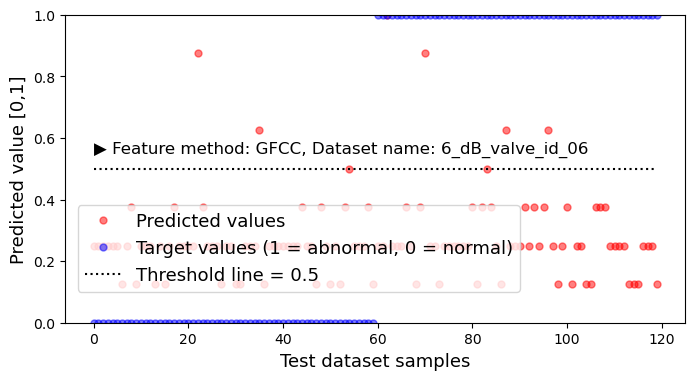

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:20
*********************************


Processing: 100%|██████████| 991/991 [03:56<00:00,  4.20it/s]


Model predicted: ROC AUC=0.789


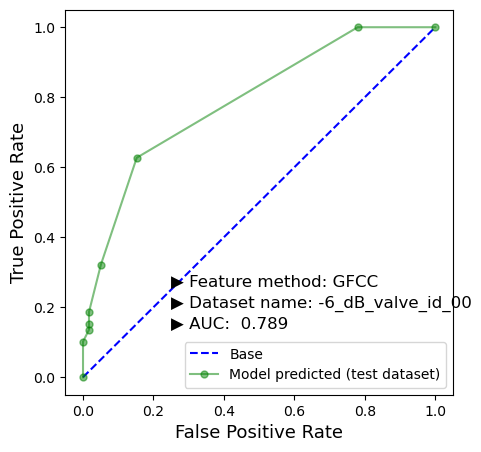

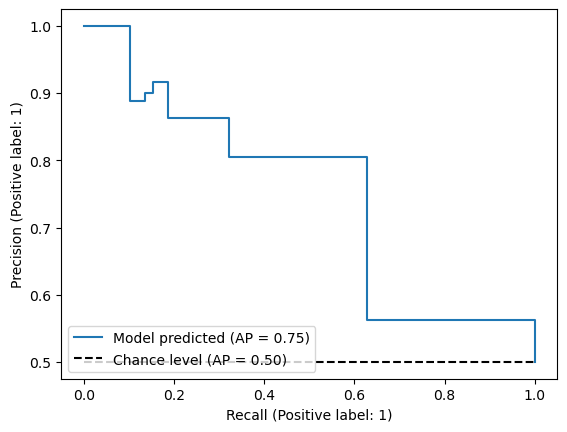

<Figure size 640x480 with 0 Axes>

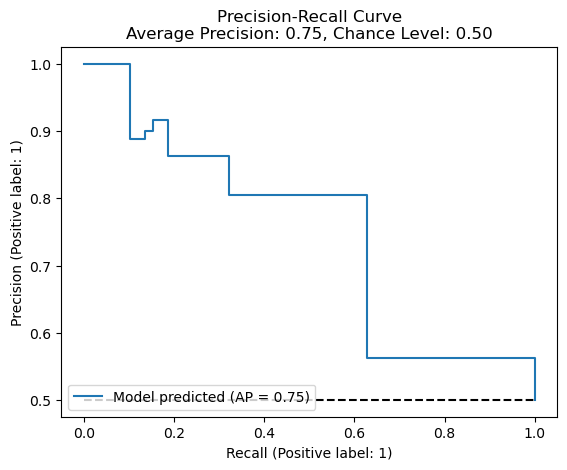

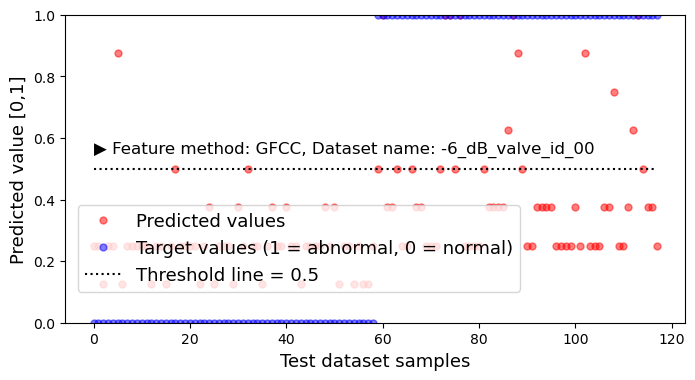

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:21
*********************************


Processing: 100%|██████████| 708/708 [02:51<00:00,  4.12it/s]


Model predicted: ROC AUC=0.556


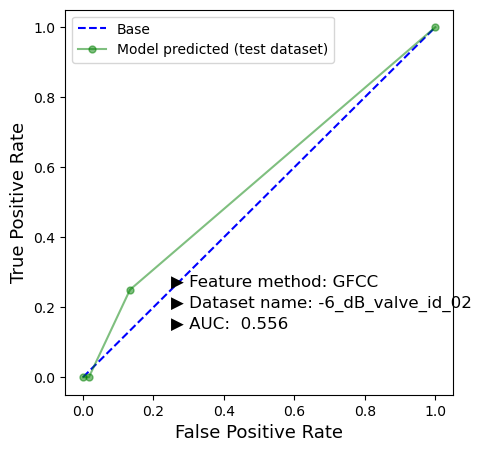

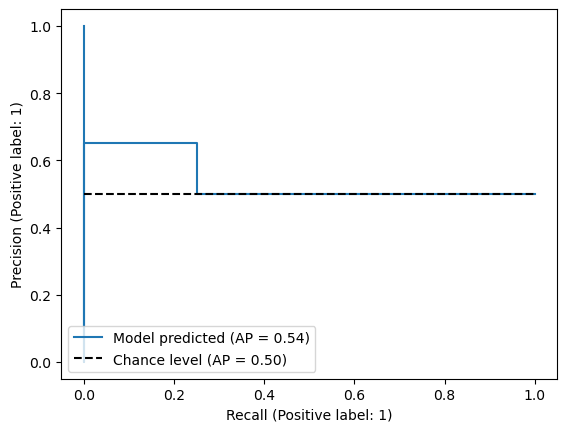

<Figure size 640x480 with 0 Axes>

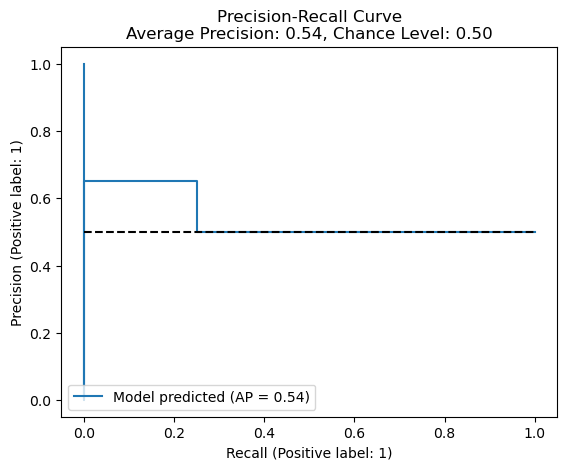

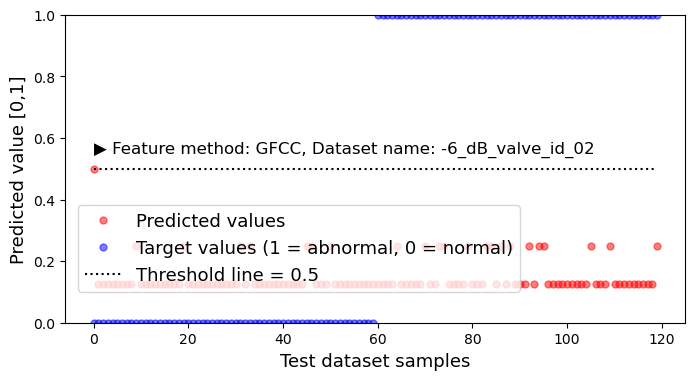

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:22
*********************************


Processing: 100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]


Model predicted: ROC AUC=0.582


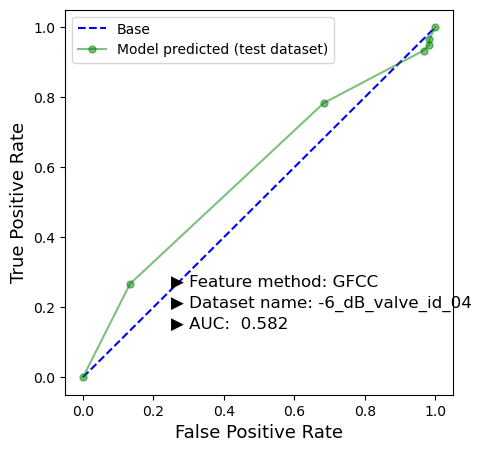

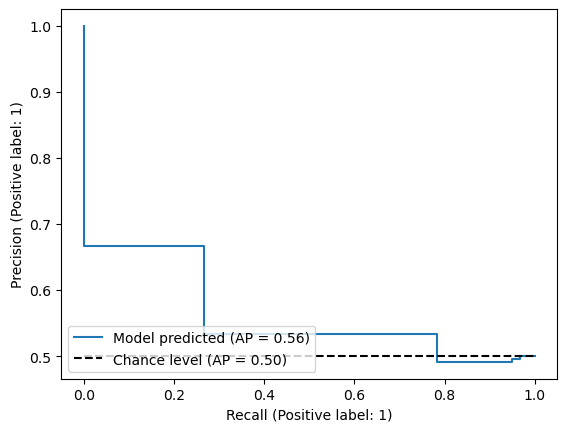

<Figure size 640x480 with 0 Axes>

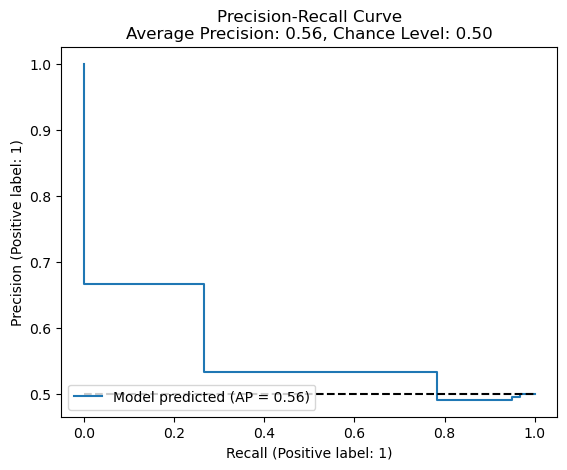

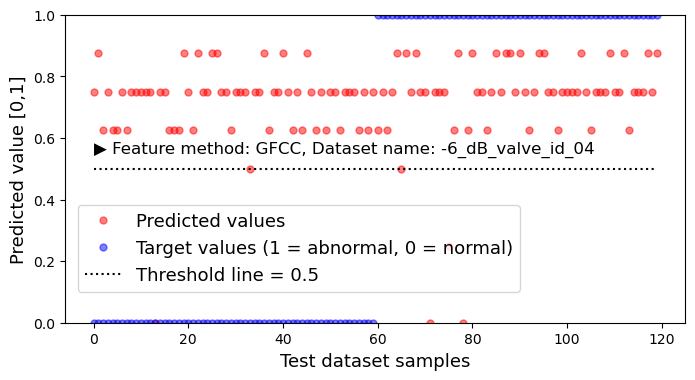

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:23
*********************************


Processing: 100%|██████████| 992/992 [03:59<00:00,  4.14it/s]


Model predicted: ROC AUC=0.519


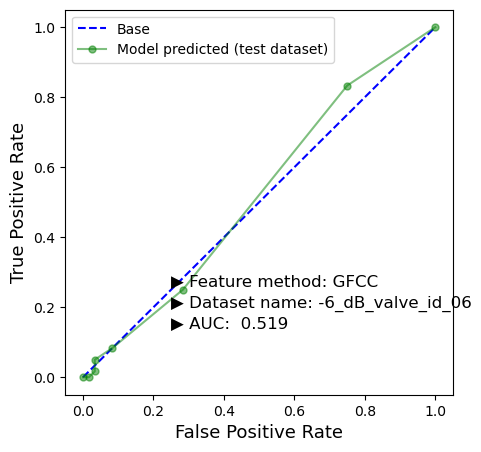

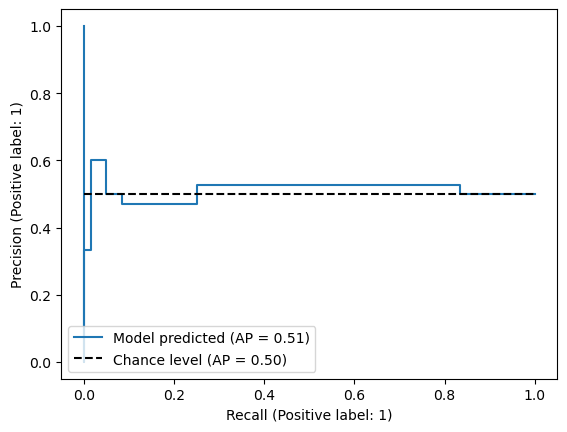

<Figure size 640x480 with 0 Axes>

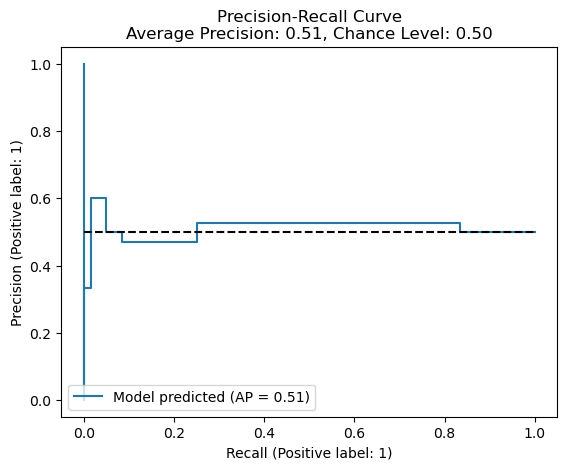

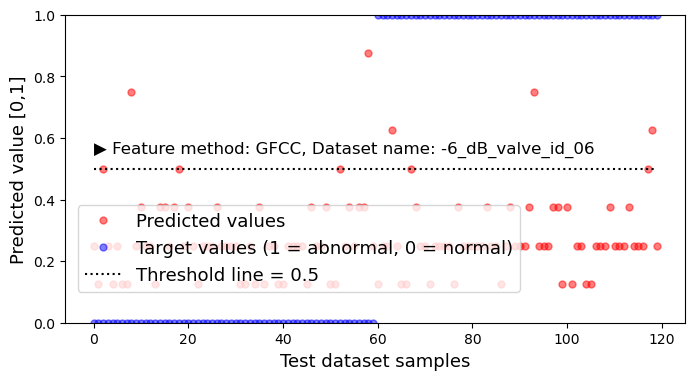

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:24
*********************************


Processing: 100%|██████████| 1068/1068 [04:24<00:00,  4.03it/s]


Model predicted: ROC AUC=0.700


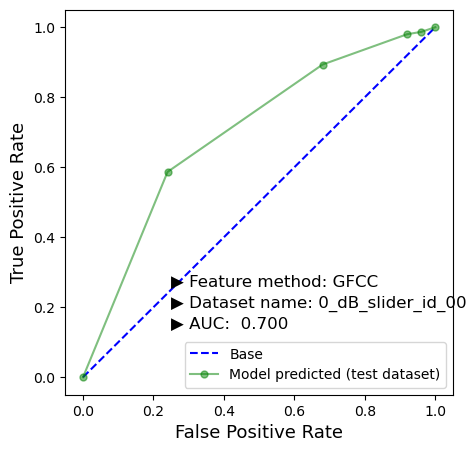

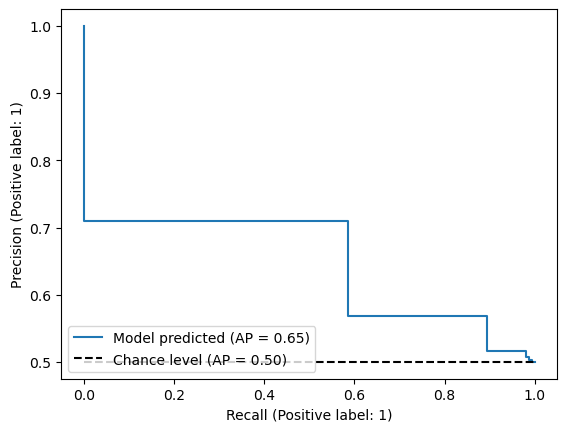

<Figure size 640x480 with 0 Axes>

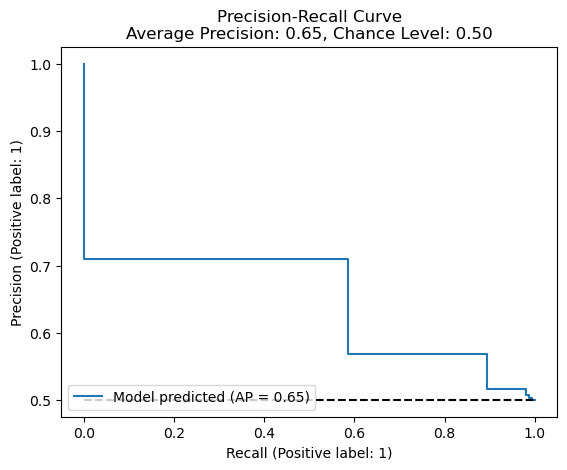

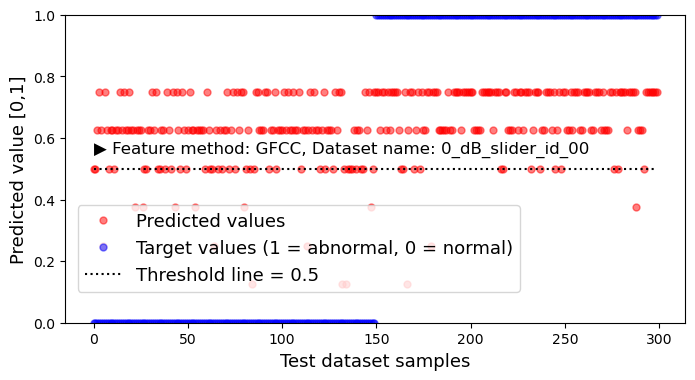

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:25
*********************************


Processing: 100%|██████████| 1068/1068 [04:16<00:00,  4.16it/s]


Model predicted: ROC AUC=0.562


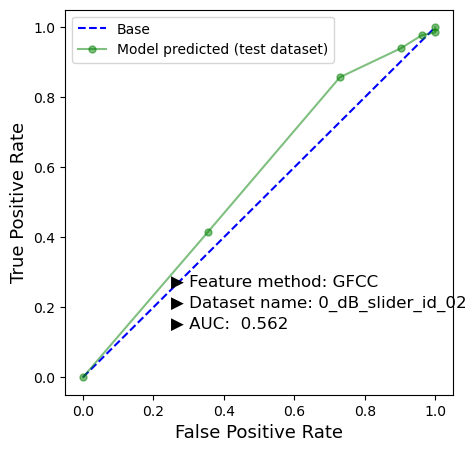

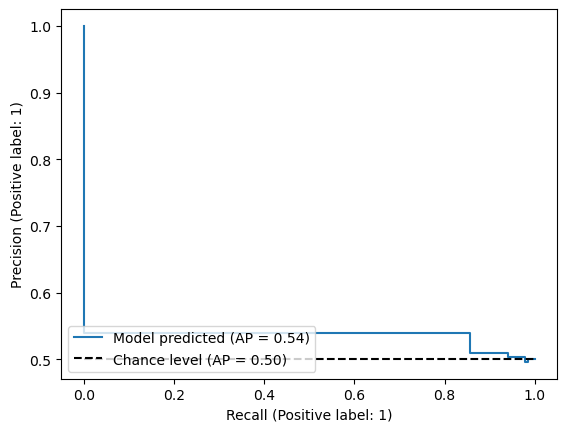

<Figure size 640x480 with 0 Axes>

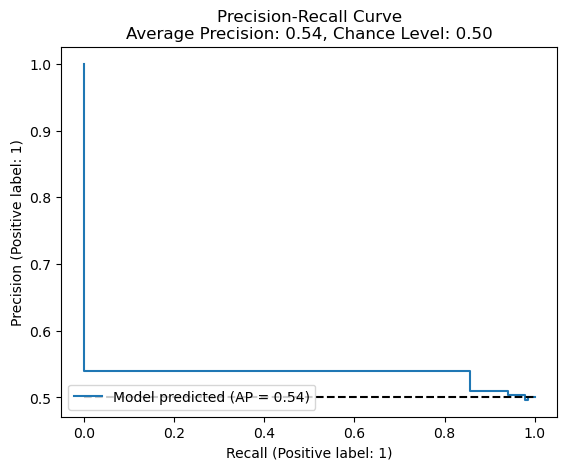

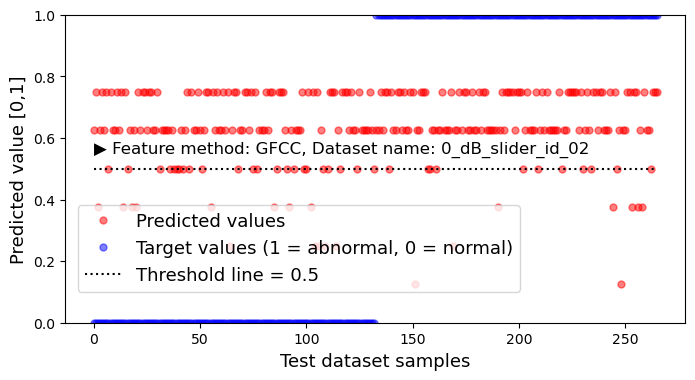

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:26
*********************************


Processing: 100%|██████████| 534/534 [02:08<00:00,  4.14it/s]


Model predicted: ROC AUC=0.511


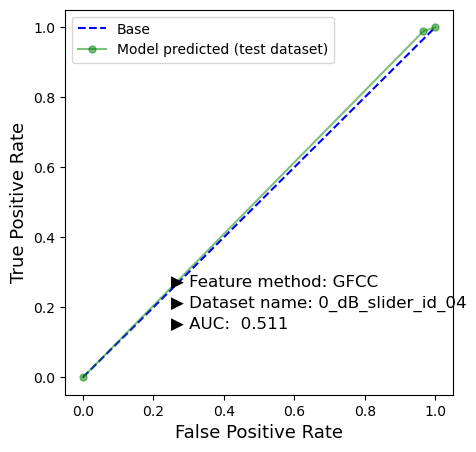

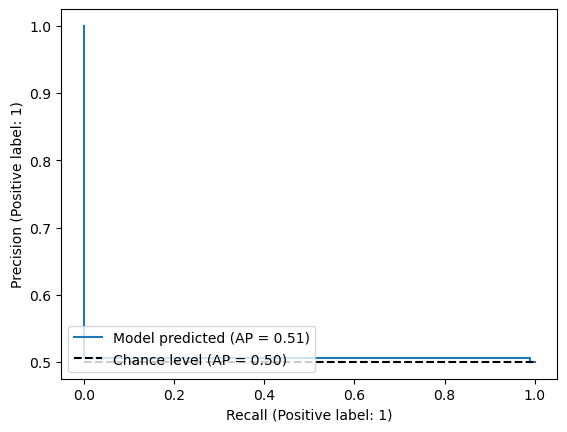

<Figure size 640x480 with 0 Axes>

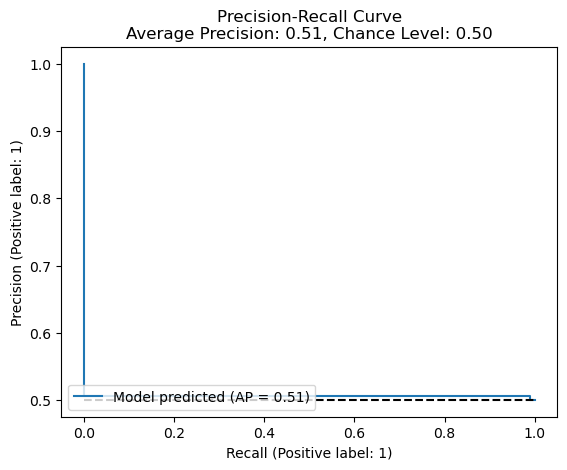

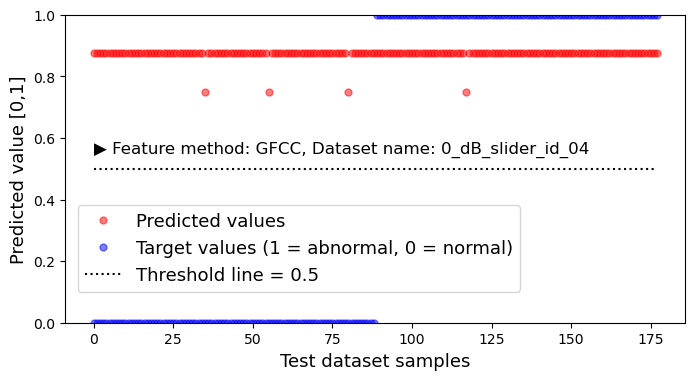

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:27
*********************************


Processing: 100%|██████████| 534/534 [02:07<00:00,  4.18it/s]


Model predicted: ROC AUC=0.511


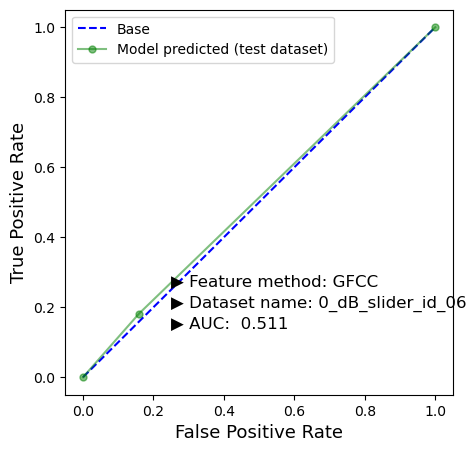

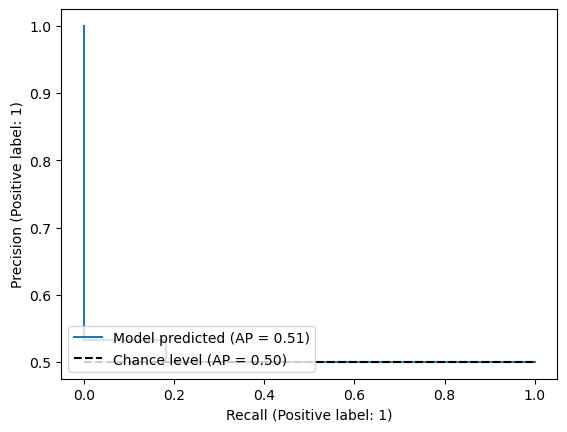

<Figure size 640x480 with 0 Axes>

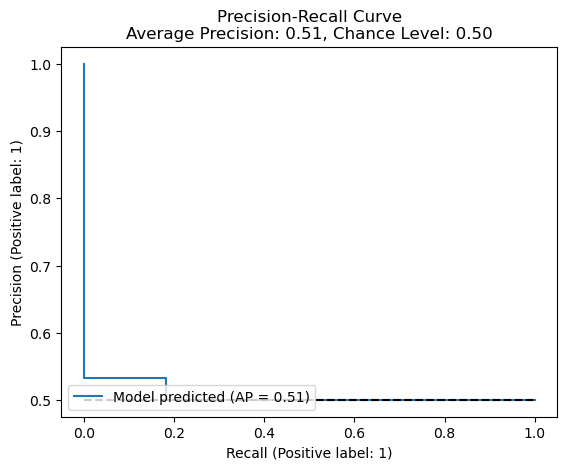

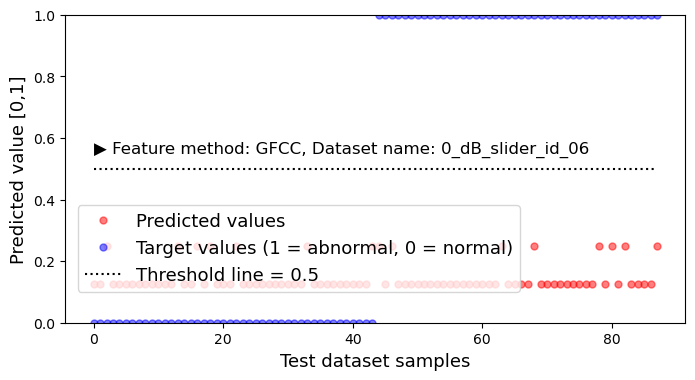

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:28
*********************************


Processing: 100%|██████████| 1068/1068 [04:14<00:00,  4.20it/s]


Model predicted: ROC AUC=0.699


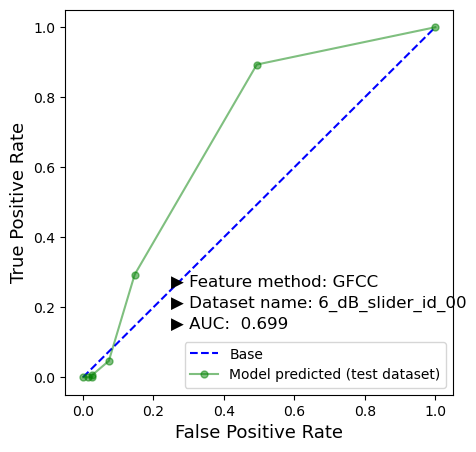

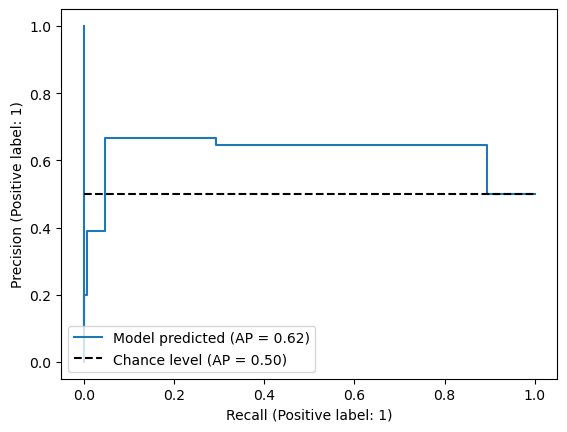

<Figure size 640x480 with 0 Axes>

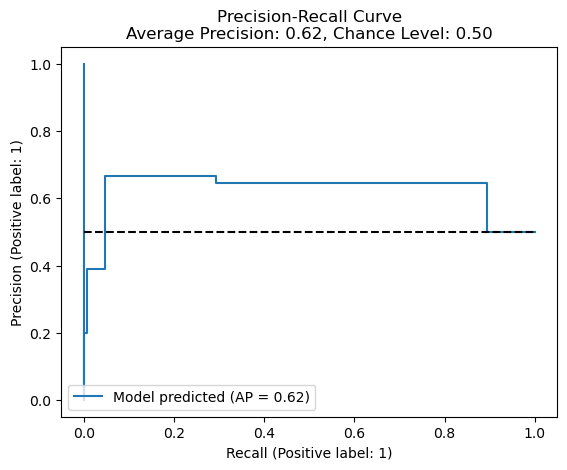

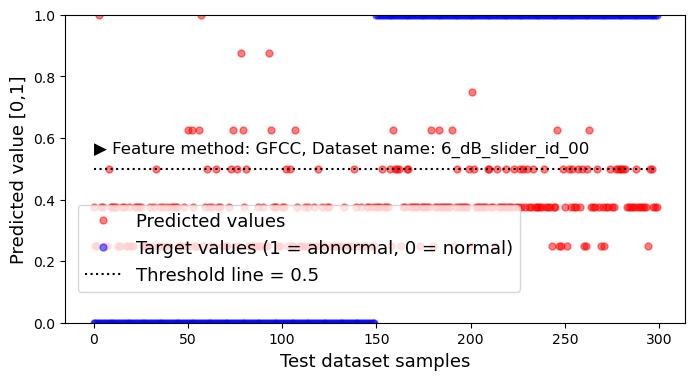

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:29
*********************************


Processing: 100%|██████████| 1068/1068 [04:05<00:00,  4.35it/s]


Model predicted: ROC AUC=0.506


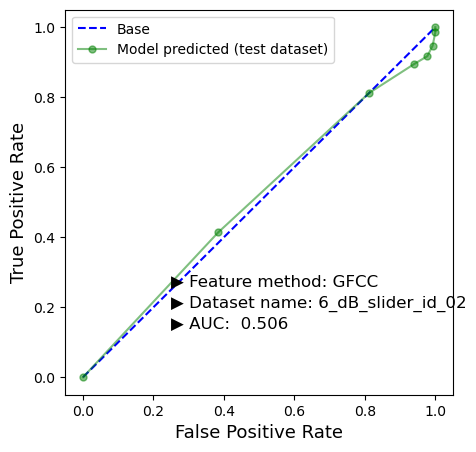

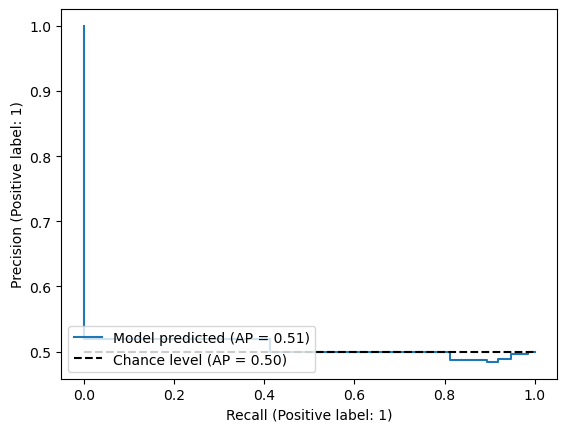

<Figure size 640x480 with 0 Axes>

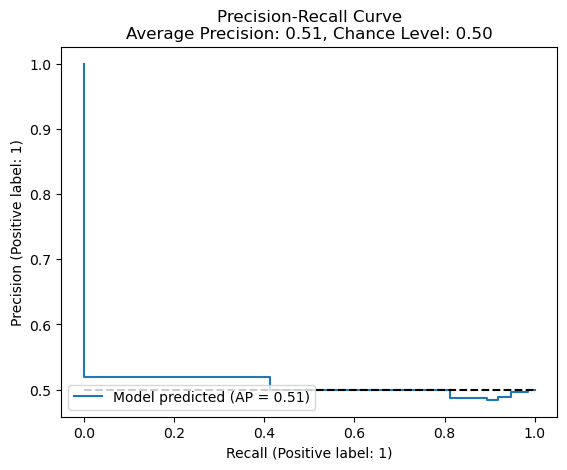

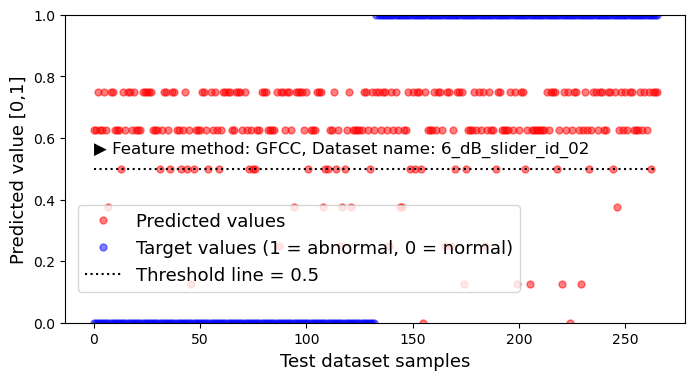

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:30
*********************************


Processing: 100%|██████████| 534/534 [02:02<00:00,  4.36it/s]


Model predicted: ROC AUC=0.500


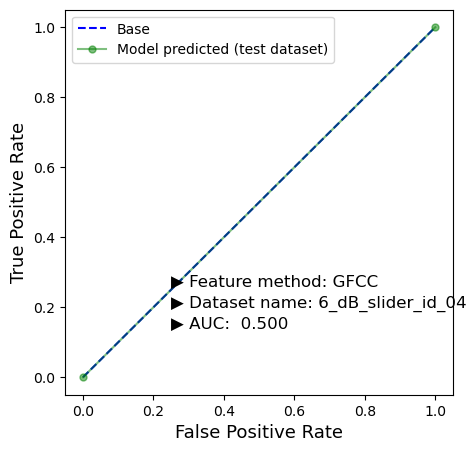

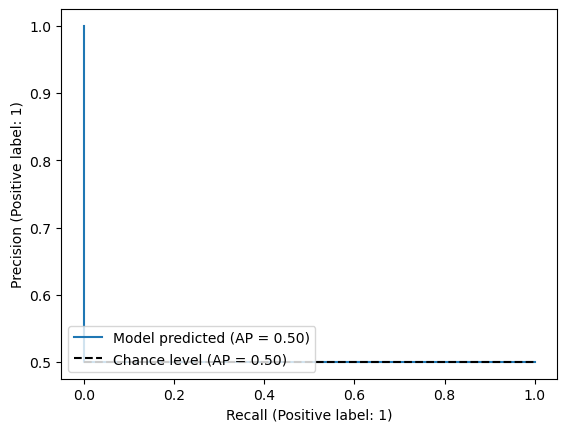

<Figure size 640x480 with 0 Axes>

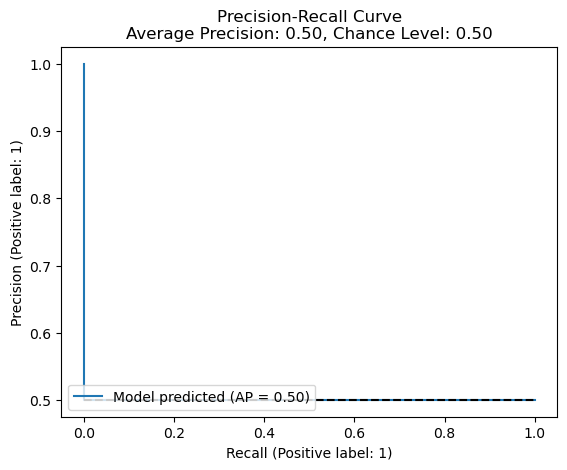

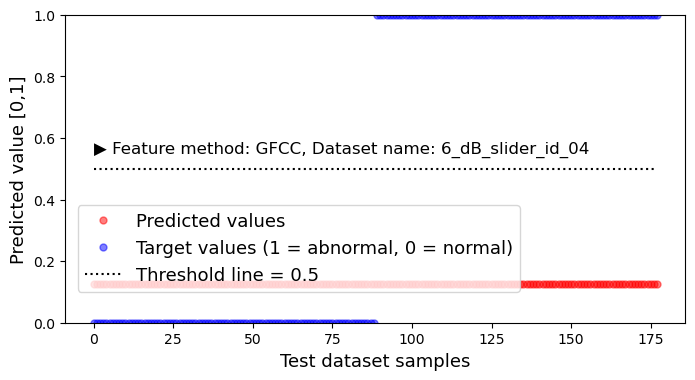

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:31
*********************************


Processing: 100%|██████████| 534/534 [02:02<00:00,  4.35it/s]


Model predicted: ROC AUC=0.500


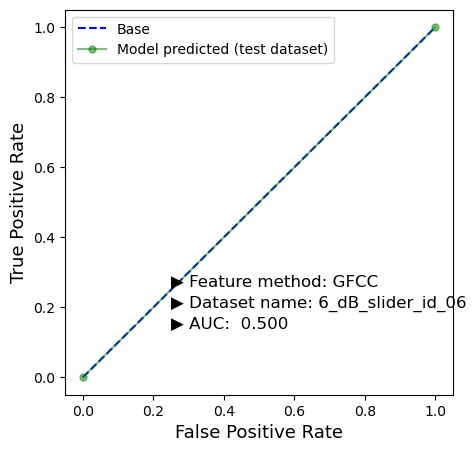

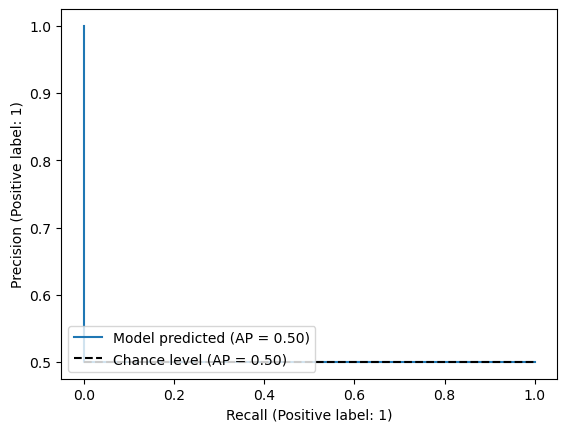

<Figure size 640x480 with 0 Axes>

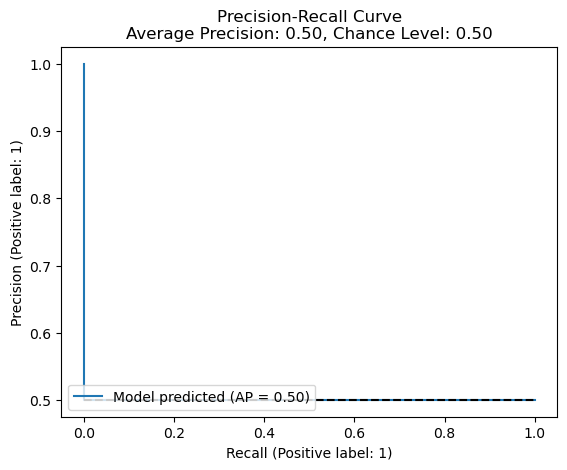

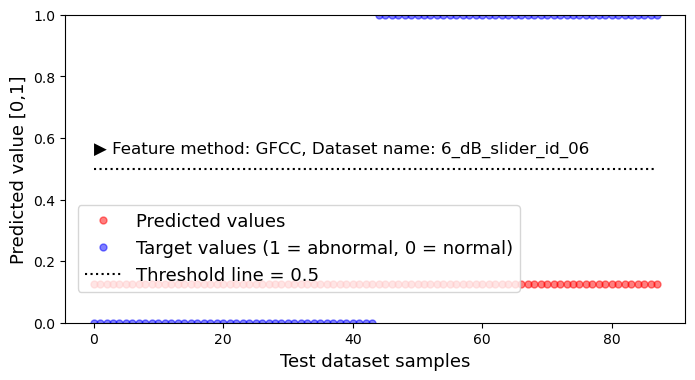

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:32
*********************************


Processing: 100%|██████████| 1068/1068 [04:05<00:00,  4.35it/s]


Model predicted: ROC AUC=0.664


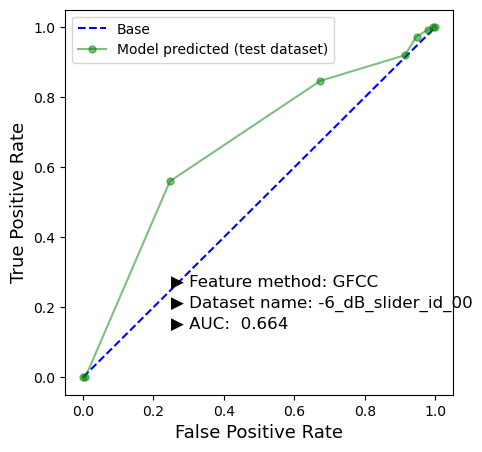

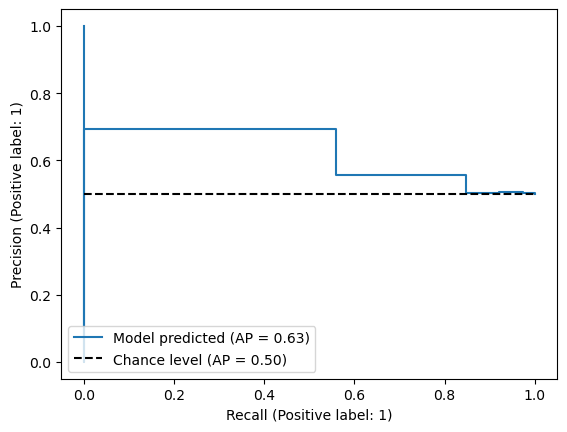

<Figure size 640x480 with 0 Axes>

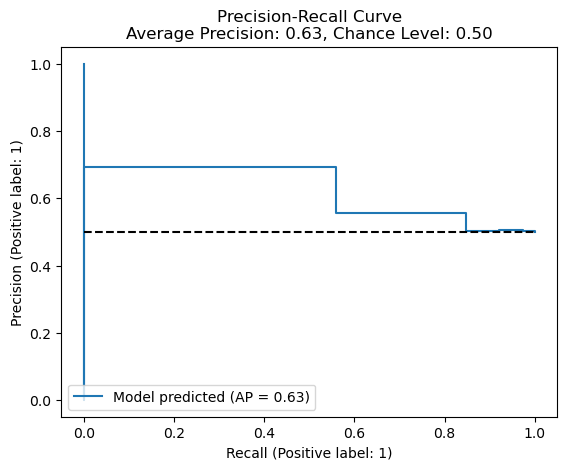

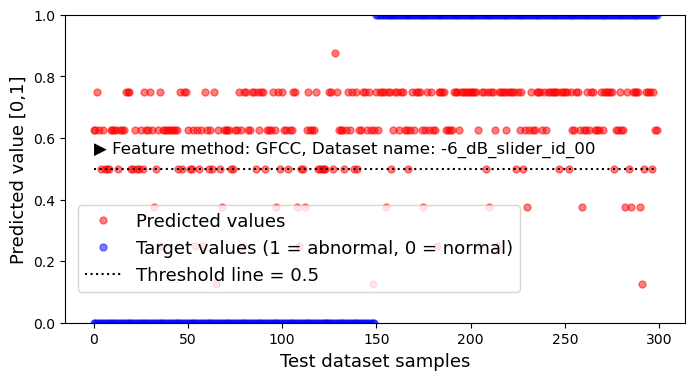

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:33
*********************************


Processing: 100%|██████████| 1068/1068 [04:05<00:00,  4.35it/s]


Model predicted: ROC AUC=0.523


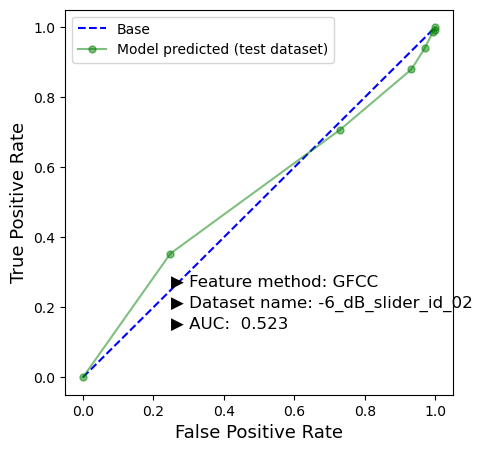

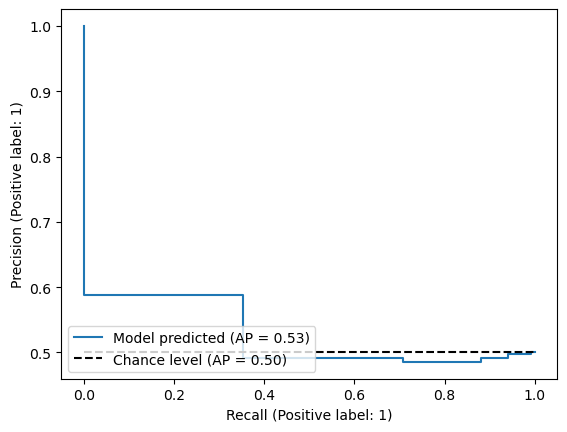

<Figure size 640x480 with 0 Axes>

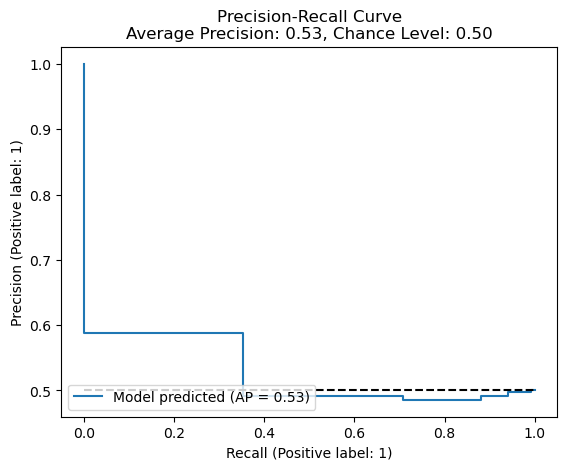

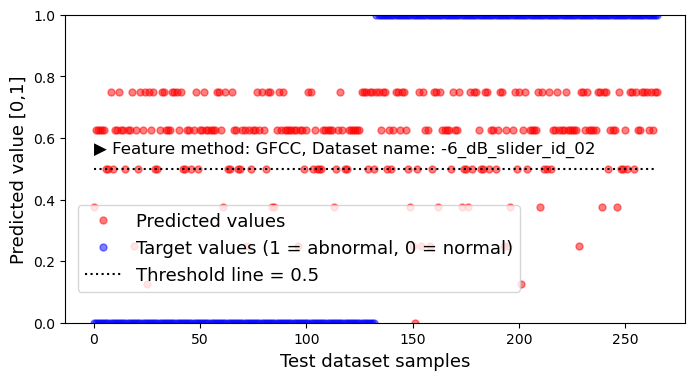

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:34
*********************************


Processing: 100%|██████████| 534/534 [02:02<00:00,  4.35it/s]


Model predicted: ROC AUC=0.558


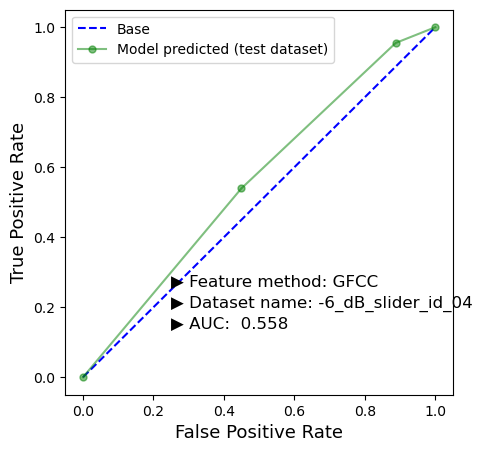

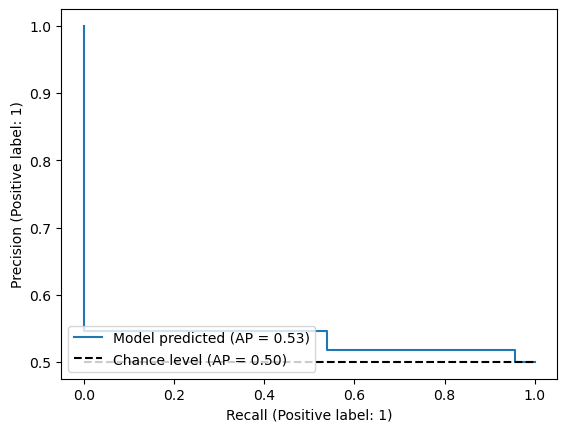

<Figure size 640x480 with 0 Axes>

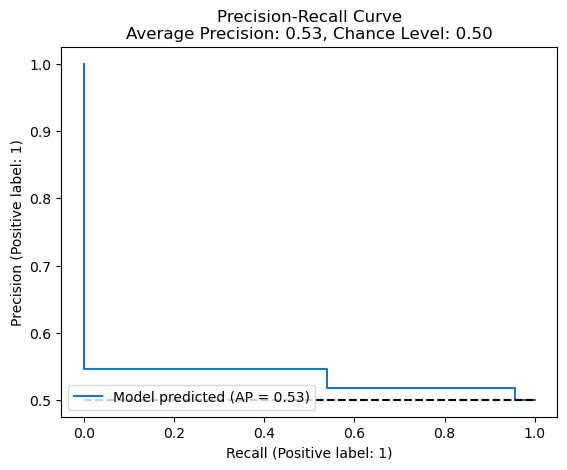

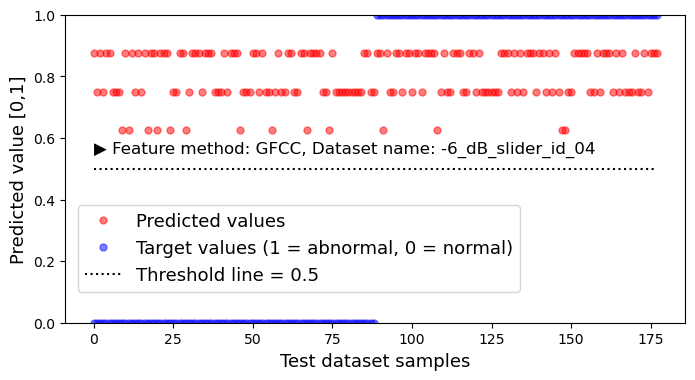

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:35
*********************************


Processing: 100%|██████████| 534/534 [02:02<00:00,  4.35it/s]


Model predicted: ROC AUC=0.583


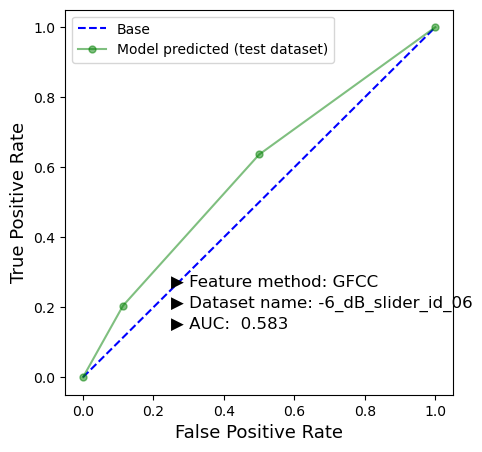

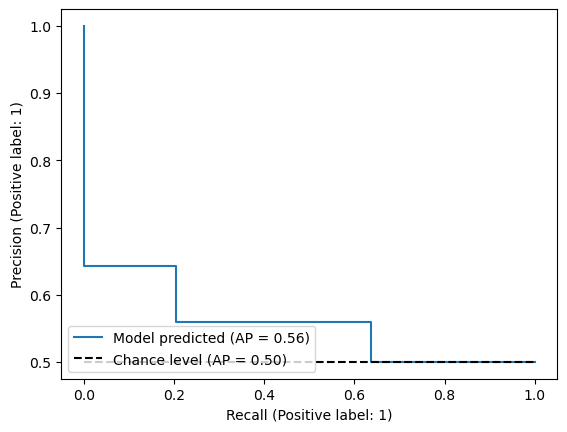

<Figure size 640x480 with 0 Axes>

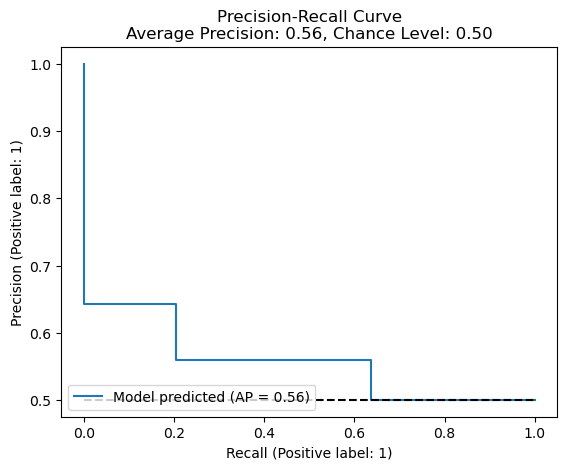

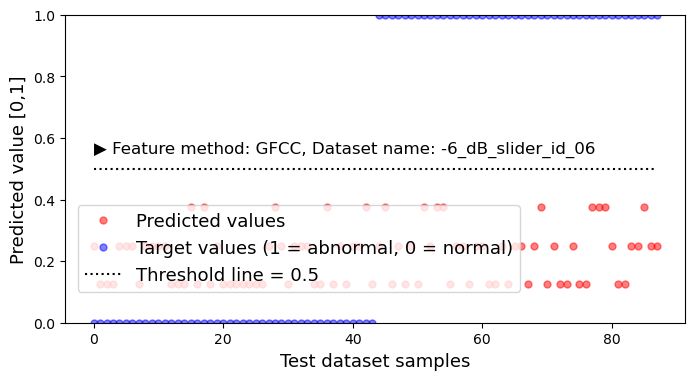

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:36
*********************************


Processing: 100%|██████████| 1006/1006 [03:51<00:00,  4.35it/s]


Model predicted: ROC AUC=0.521


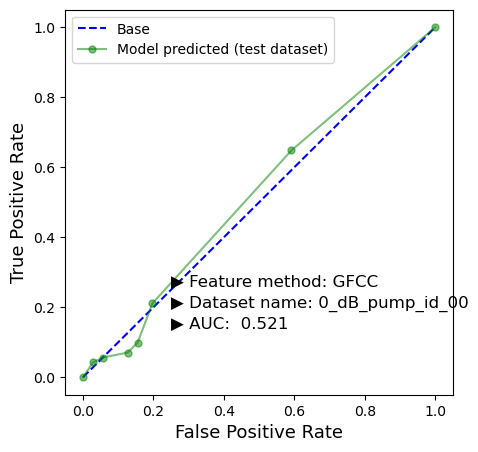

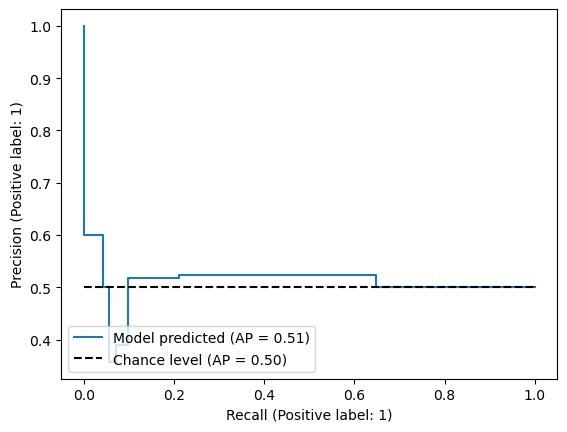

<Figure size 640x480 with 0 Axes>

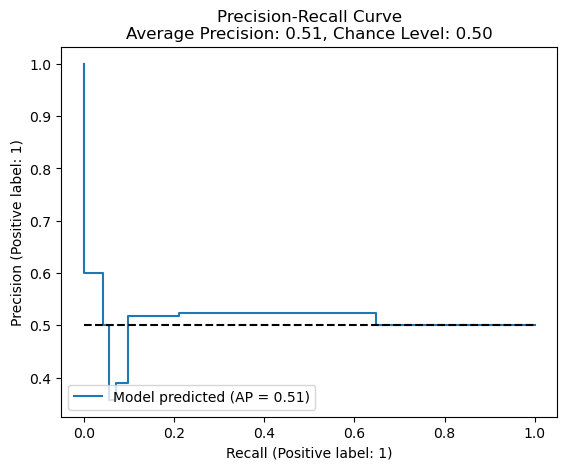

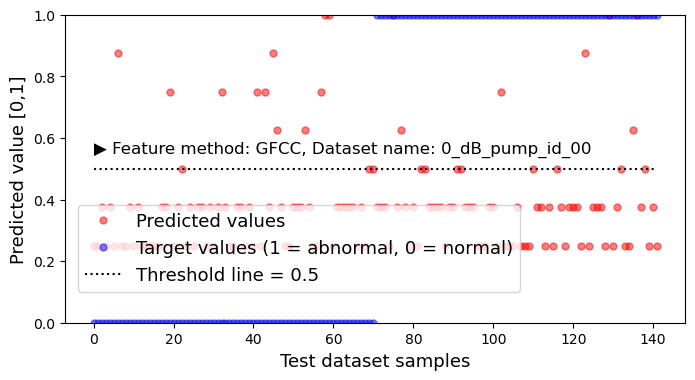

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:37
*********************************


Processing: 100%|██████████| 1005/1005 [03:51<00:00,  4.34it/s]


Model predicted: ROC AUC=0.547


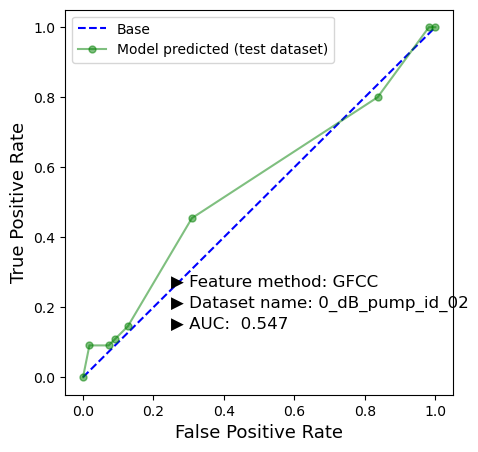

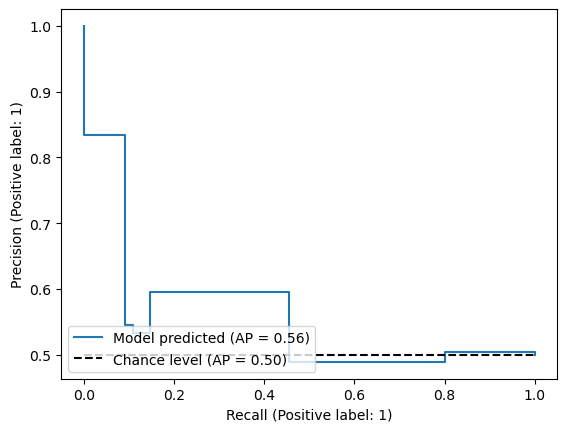

<Figure size 640x480 with 0 Axes>

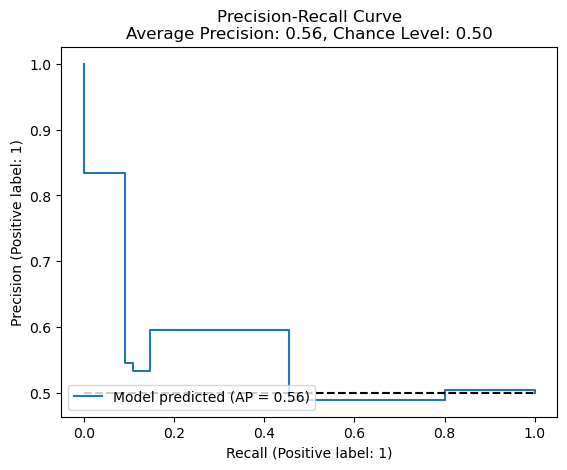

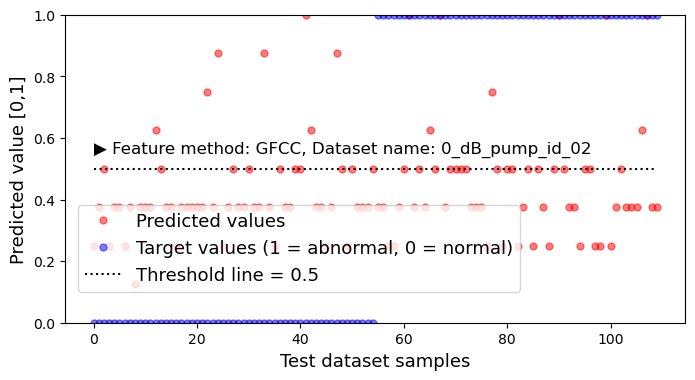

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:38
*********************************


Processing: 100%|██████████| 702/702 [02:41<00:00,  4.34it/s]


Model predicted: ROC AUC=0.513


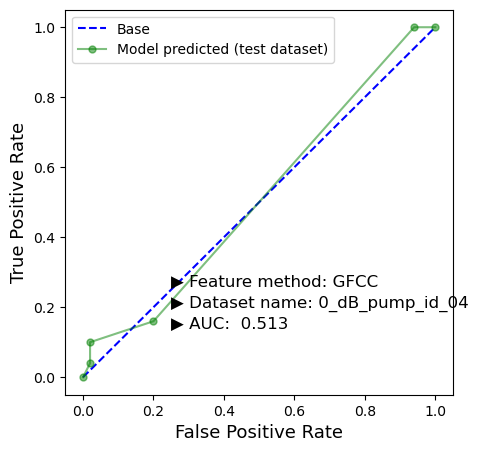

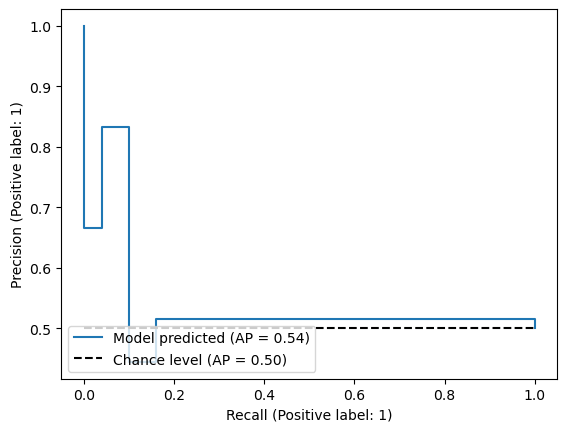

<Figure size 640x480 with 0 Axes>

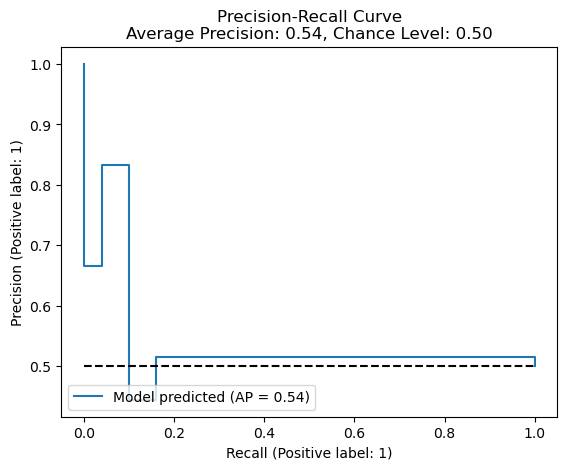

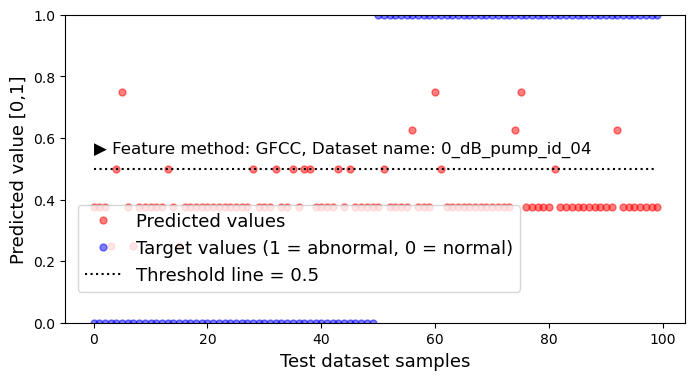

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:39
*********************************


Processing: 100%|██████████| 1036/1036 [03:58<00:00,  4.34it/s]


Model predicted: ROC AUC=0.563


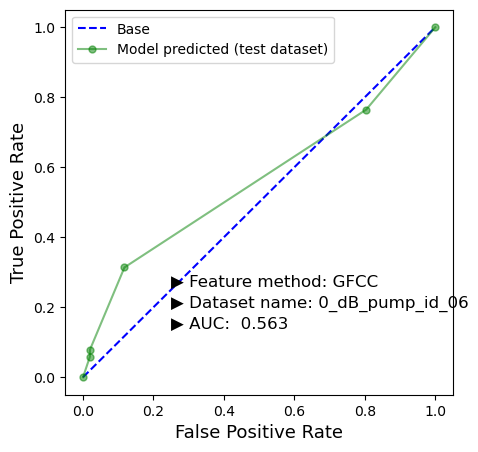

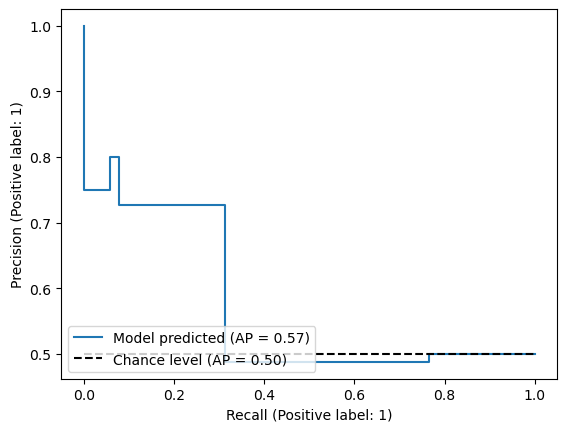

<Figure size 640x480 with 0 Axes>

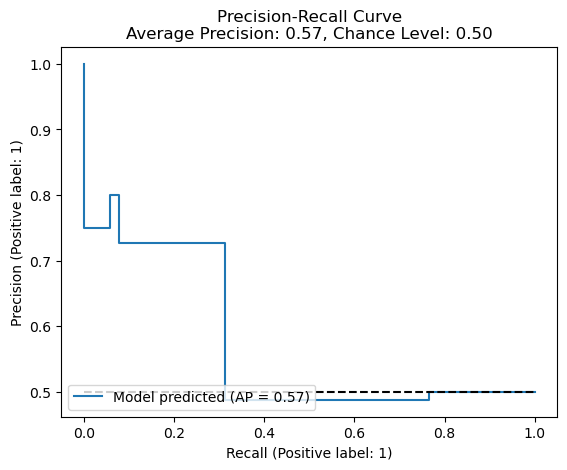

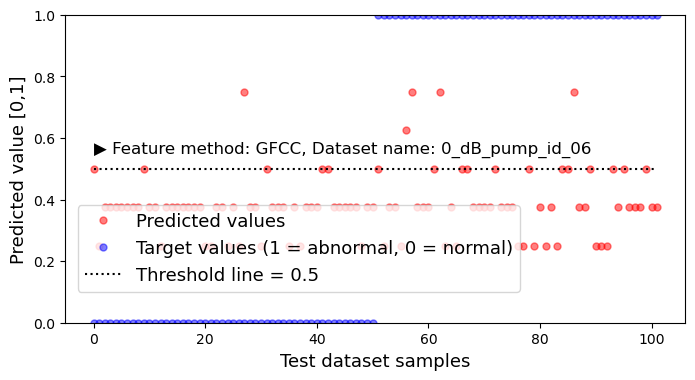

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:40
*********************************


Processing: 100%|██████████| 1006/1006 [03:51<00:00,  4.34it/s]


Model predicted: ROC AUC=0.707


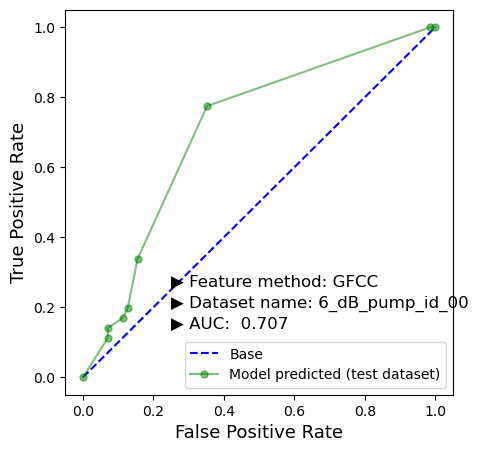

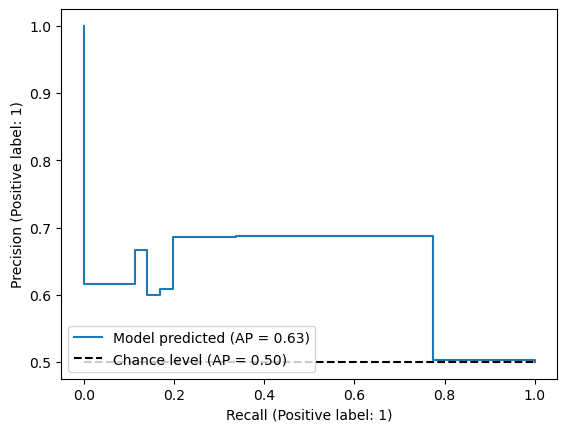

<Figure size 640x480 with 0 Axes>

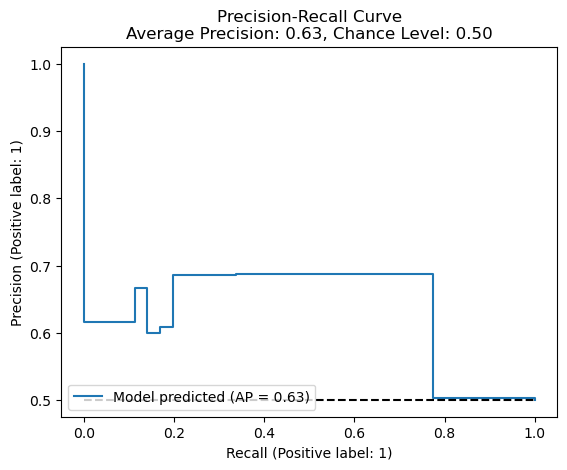

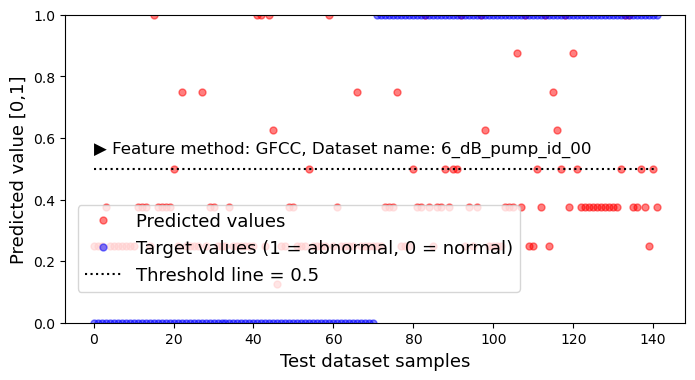

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:41
*********************************


Processing: 100%|██████████| 1005/1005 [03:51<00:00,  4.33it/s]


Model predicted: ROC AUC=0.651


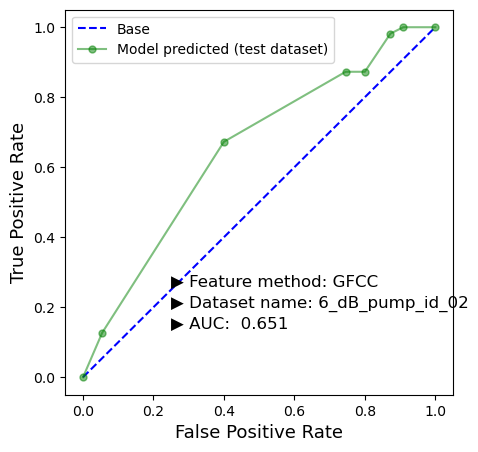

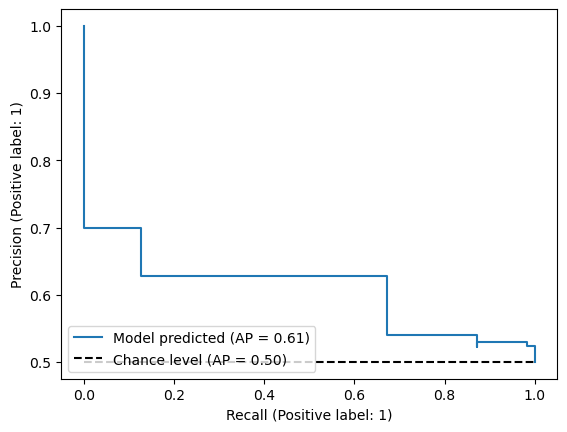

<Figure size 640x480 with 0 Axes>

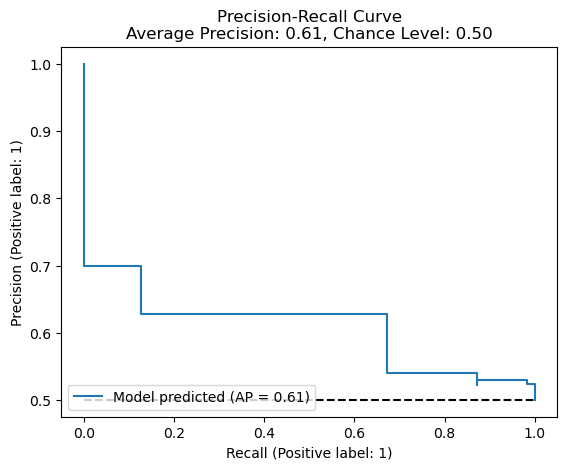

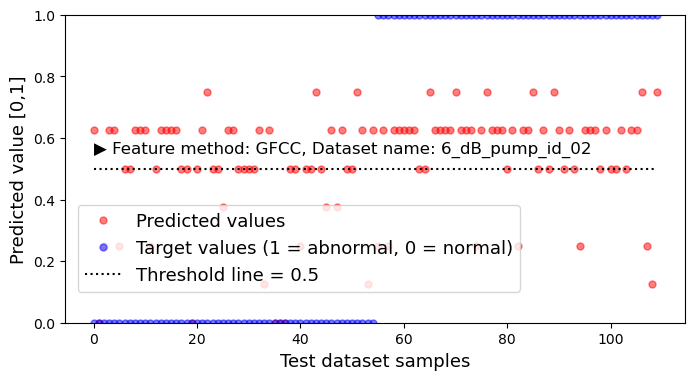

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:42
*********************************


Processing: 100%|██████████| 702/702 [02:41<00:00,  4.35it/s]


Model predicted: ROC AUC=0.523


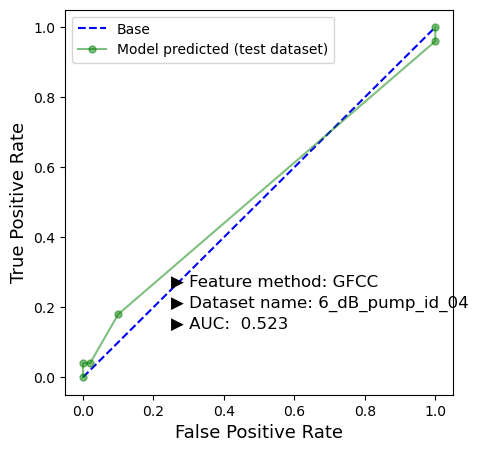

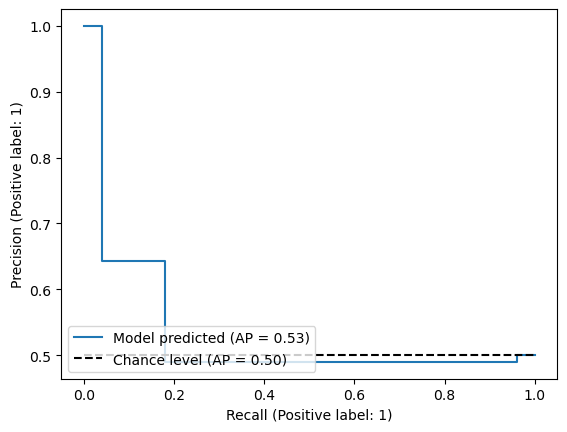

<Figure size 640x480 with 0 Axes>

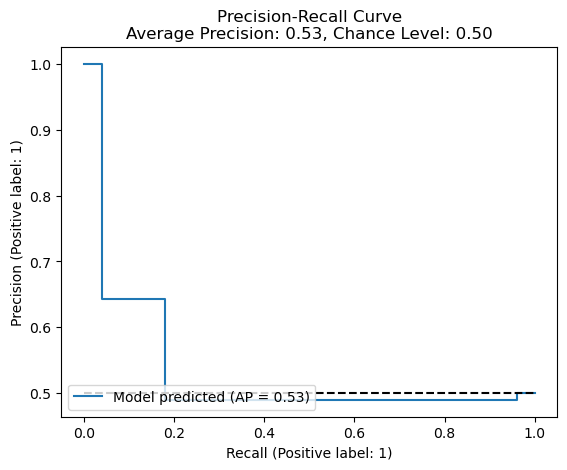

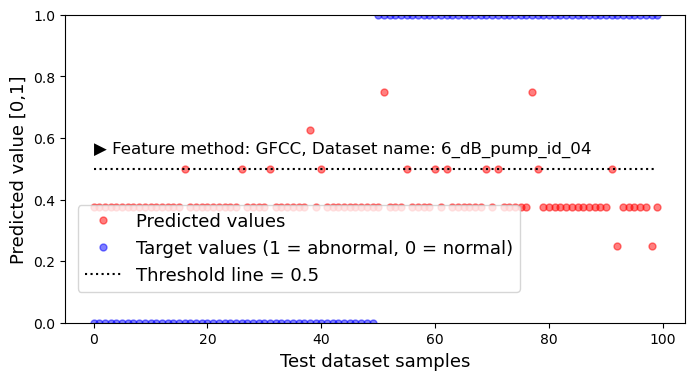

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:43
*********************************


Processing: 100%|██████████| 1036/1036 [03:59<00:00,  4.33it/s]


Model predicted: ROC AUC=0.511


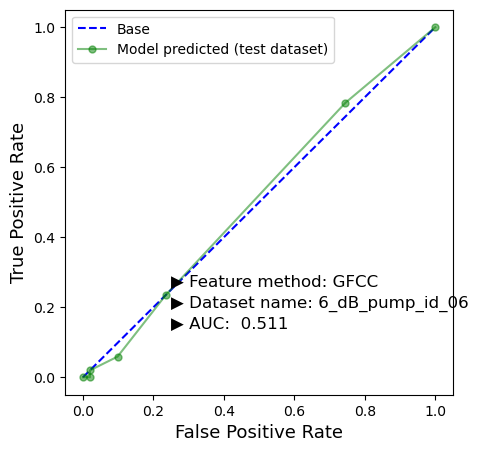

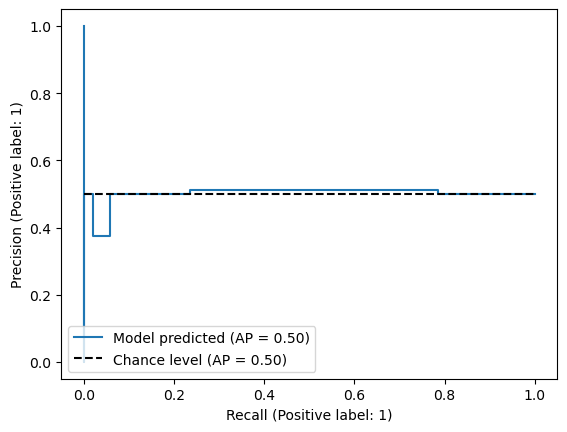

<Figure size 640x480 with 0 Axes>

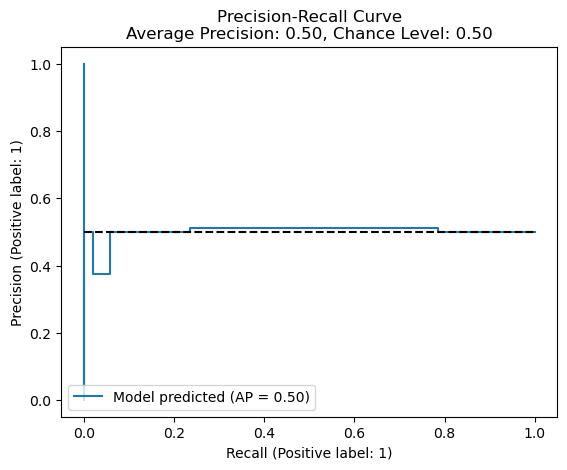

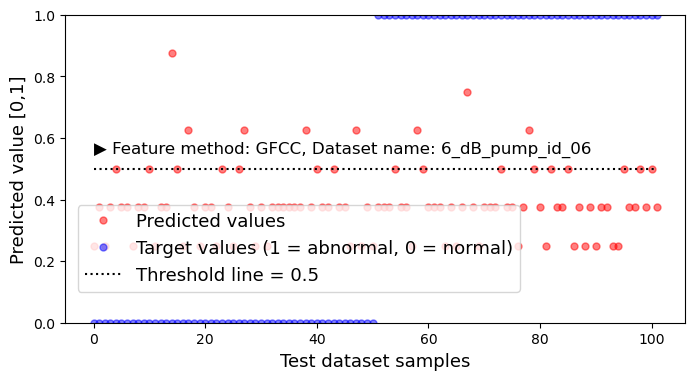

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:44
*********************************


Processing: 100%|██████████| 1006/1006 [03:52<00:00,  4.33it/s]


Model predicted: ROC AUC=0.542


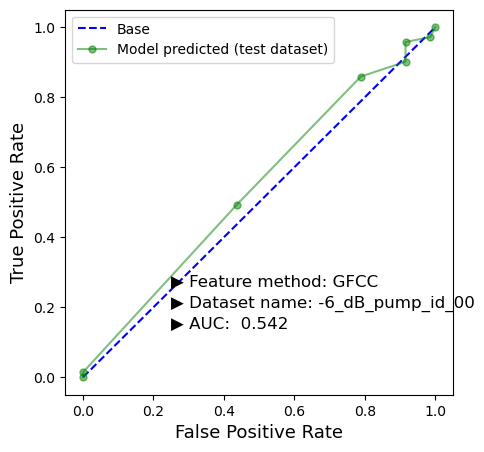

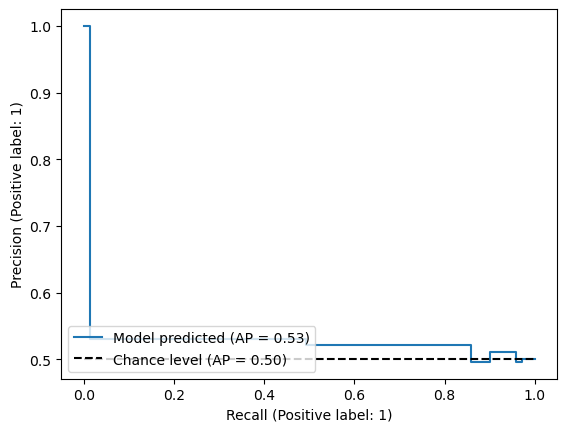

<Figure size 640x480 with 0 Axes>

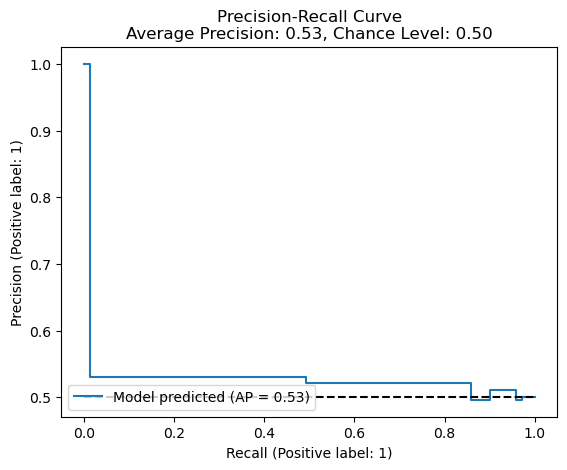

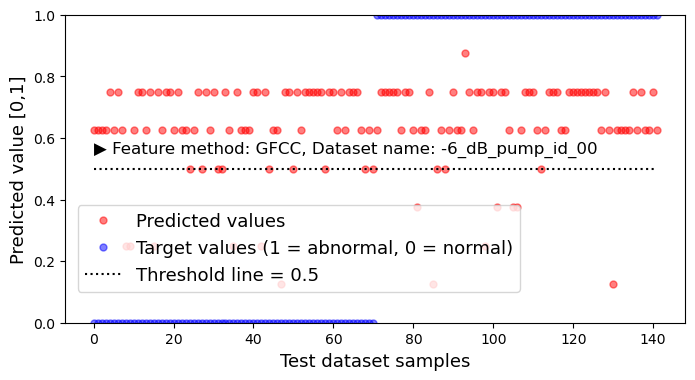

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:45
*********************************


Processing: 100%|██████████| 1005/1005 [03:51<00:00,  4.34it/s]


Model predicted: ROC AUC=0.601


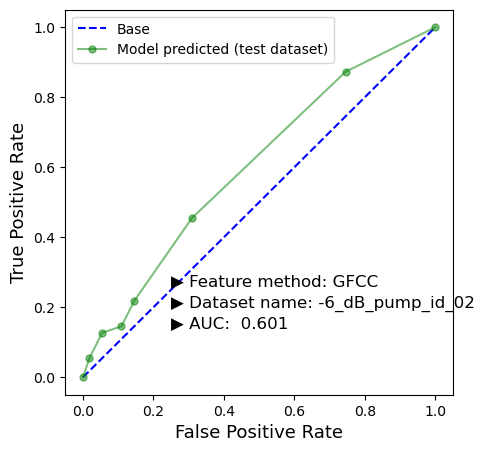

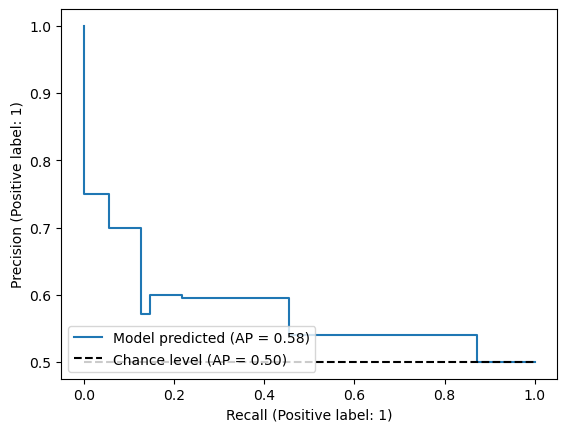

<Figure size 640x480 with 0 Axes>

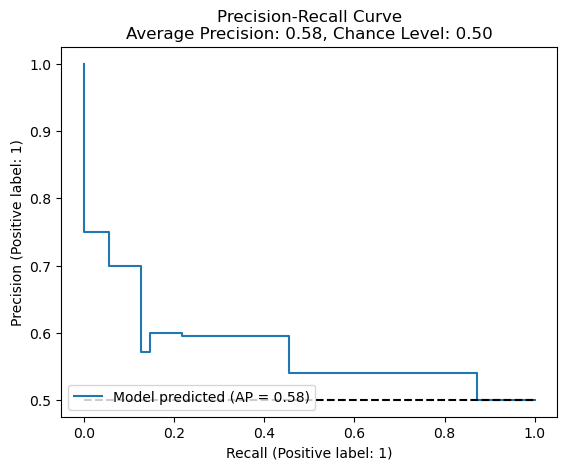

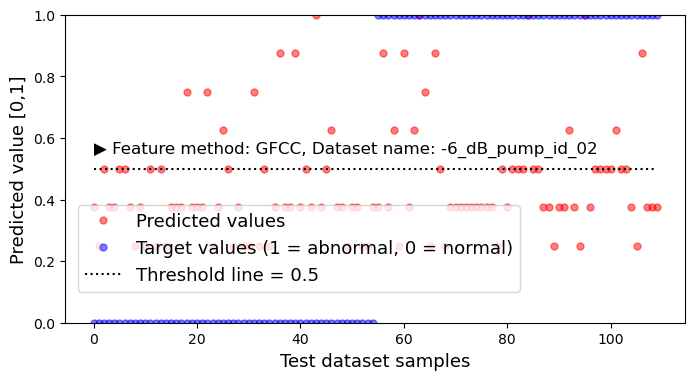

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:46
*********************************


Processing: 100%|██████████| 702/702 [02:41<00:00,  4.35it/s]


Model predicted: ROC AUC=0.500


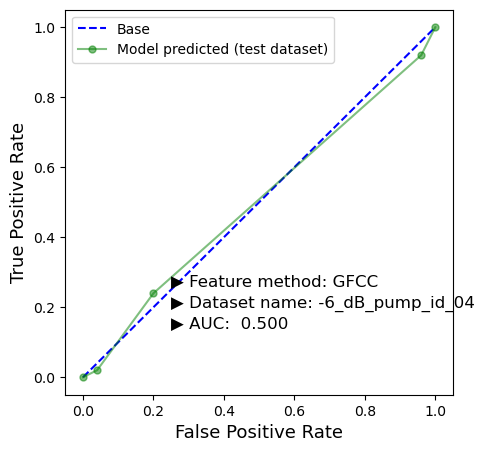

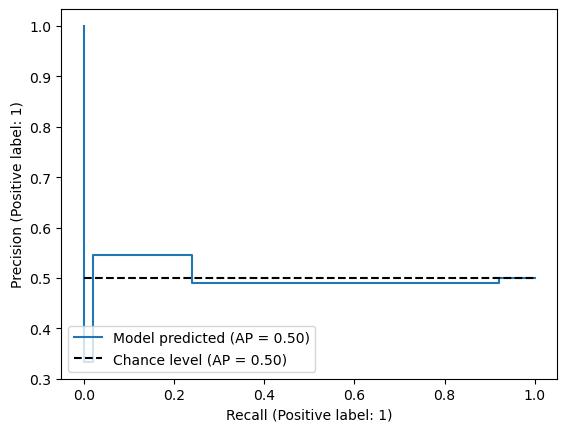

<Figure size 640x480 with 0 Axes>

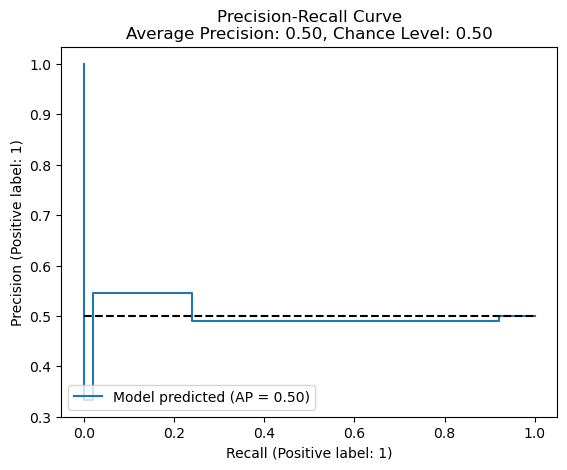

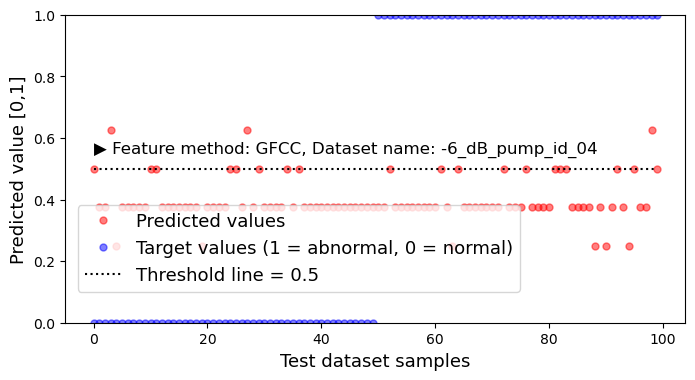

C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


*********************************
*********************************
Iteration:47
*********************************


Processing: 100%|██████████| 1036/1036 [03:58<00:00,  4.34it/s]


Model predicted: ROC AUC=0.556


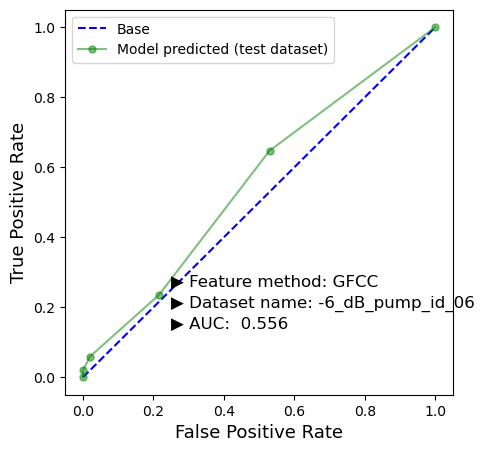

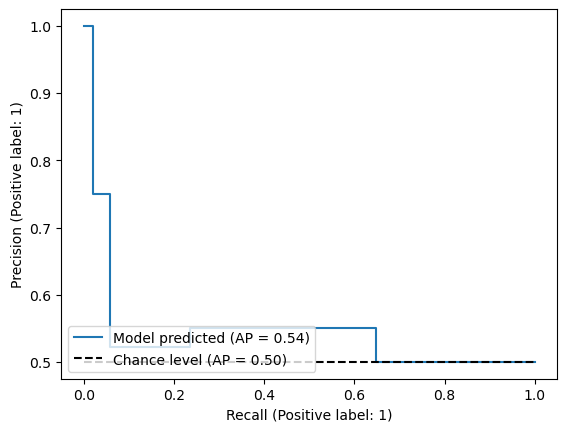

<Figure size 640x480 with 0 Axes>

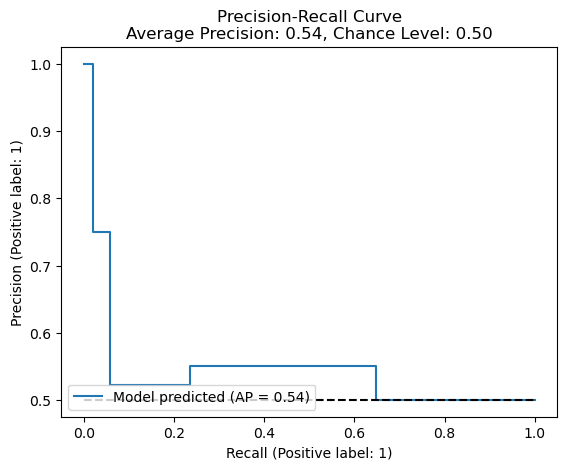

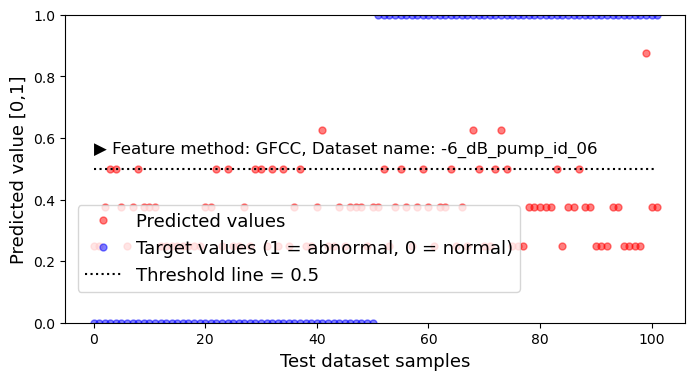

*********************************


C:\Users\HP\AppData\Local\Temp\ipykernel_11196\1956432141.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saved_results=df_saved_results.append(result,ignore_index=True)


In [13]:
input_dir=direc_out
i=0
for direc in input_dir:
    print("*********************************")
    print("Iteration:{}".format(i))
    print("*********************************")
    feature_=direc.split('\\')[1]
    dataset_=direc.split('\\')[2]+"_"+direc.split('\\')[3]
    aug_train,aug_test,train_labels,test_labels=extract_shuffle(direc)
    result=results_graphs(aug_train,aug_test,train_labels,test_labels,feature_,dataset_)
    result_list.append(result)
    df_saved_results=df_saved_results.append(result,ignore_index=True)
    df_saved_results.to_csv('output_GFCC.csv', index=False)
    print("*********************************")
    i=i+1